# Week 2 - Counting Words & Phrases (Computational Linguistics)
This week, we take text corpora that we have developed, spidered, scraped, and encoded, and we find and count words, simple and parsed phrases and explore the statistical properties of those counts (e.g., word frequency distributions). Initially, we model how to search corpora for keywords or phrases. Next, we examine the distributions of terms and phrases across a corpus, and the correlation between different words and phrase counts. In order to do this effectively, we coarsely disambiguate words based of part-of-speech (POS) tagging, and normalize them through stemming and lemmatization. Next we distinguish *important* words and phrase within the corpus, and image them with Wordls! Then we calculate word frequenceis, conditional frequences (the frequency of word *shock* conditional on the presence of word *awe*), and statistically significant collocations of lengths 2 through $n$. Finally, we calculate and visualize Differences (Divergences and Distances) between the word frequency distributions from two corpora.

Then we shift to focus not simply on the *ideas* in a corpus, but also extracting precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases.

We will be introducing spaCy as a package for Computational Linguistics, and also walk you through how to use the Davies Corpora.

While we wish to avoid using NLTK for heavy corpus analysis, some of its smaller functions can still be useful.

Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text.

For this notebook we will be using the following packages:


In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
# !pip install git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import lucem_illud #just in case, regularly update your lucem_illud with the following code: pip install git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

# Retrieving exemplary corpora

To get started we will need some examples. Let's start by downloading one of the corpuses from the Davies set purchased for this class and developed by a computational linguist at Brigham Young University. We can get a list of works available from the [corpora here](https://www.english-corpora.org/).

In this notebook, I will be accessing the data locally - you also have access to this data through the Dropbox download link (shared on Canvas, not here, because the GitHub is publically accessible). The same code can be modified slighlty to access the rest of the corpora on RCC. There is a notebook describing this process in the same repository, as well as in the same directory on RCC.

In [2]:
corpus_name = "/Users/itsyuzhou/Winter2024/Content-Analysis-Homework/notebooks/week2/Movies"

# corpus_name = "Movies"

Just to be clear, your corpus_name should be different since you're not bhargav. Modify the corpus_name with your directory. This method extracts the text from the zip files and stroes the raw data.

In [3]:
def loadcorpus(corpus_name, corpus_style="text"):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        if corpus_style in file:
            print(file)
            zfile = zipfile.ZipFile(corpus_name + "/" + file)
            for file in zfile.namelist():
                texts_raw[file] = []
                with zfile.open(file) as f:
                    for line in f:
                        texts_raw[file].append(line)
    return texts_raw

In [4]:
movie_raw = loadcorpus(corpus_name)

text_13_idi.zip
text_16_qll.zip
text_32_ldf.zip
text_19_gvc.zip
text_05_nko.zip
text_17_arp.zip
text_01_ote.zip
text_28_rfy.zip
text_31_akv.zip
text_22_etp.zip
text_11_uoy.zip
text_09_oii.zip
text_06_jfy.zip
text_14_lnc.zip
text_08_loh.zip
text_33_kje.zip
text_30_wkp.zip
text_07_oma.zip
text_03_mnq.zip
text_21_fqa.zip
text_29_oye.zip
text_27_fle.zip
text_23_fmh.zip
text_12_rcq.zip
text_00_myn.zip
text_10_aoy.zip
text_04_mlq.zip
text_20_cde.zip
text_02_mqu.zip
text_26_ngj.zip
text_24_ywo.zip
text_18_jfj.zip
text_25_byg.zip
text_15_guo.zip


In [5]:
movie_raw['11.txt'][0:3]

[b'\r\n',
 b'@@216680 Hey , I \'m talking to you Give me 600 dollars You wish ! That \'s all we \'ve left And you still go to gamble Shut up I earn the money Even that you ca n\'t take it for gamble Shut up What \'re you doing ? Bastard , I \'m gon na beat you You gambling pig , I \'ll beat the shit out of you You bitch I \'ll beat you You dare to hit me with something ! I \'ll kill you All you know is gambling I \'ll beat you What \'re you doing ? Let go of me Stop You \'ll kill Mom Mom , are you all right ? Do n\'t touch my money Dad , where \'re you going ? Go away Dad , do n\'t go Get lost Dad , come back You take Marble with you The way she \'s now Do you want to give me trouble ? I \'m in more trouble than you I am a woman I \'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Do n\'t marry a gambler Hey , 

It seems messy, but nothing we can't clean. This basic method replaces some of the issues with the formatting, and prints the errors if any for debugging. Let us clean one of the raw text files.

We ignore the non-unicode data for convenience in our first pass.

In [6]:
def clean_raw_text(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return clean_texts

In [7]:
clean_11 = clean_raw_text(movie_raw['11.txt'])

In [8]:
clean_11[1]

'@@216680 Hey , I\'m talking to you Give me 600 dollars You wish ! That\'s all we\'ve left And you still go to gamble Shut up I earn the money Even that you can\'t take it for gamble Shut up What\'re you doing ? Bastard , I\'m gon na beat you You gambling pig , I\'ll beat the shit out of you You bitch I\'ll beat you You dare to hit me with something ! I\'ll kill you All you know is gambling I\'ll beat you What\'re you doing ? Let go of me Stop You\'ll kill Mom Mom , are you all right ? Don\'t touch my money Dad , where\'re you going ? Go away Dad , don\'t go Get lost Dad , come back You take Marble with you The way she\'s now Do you want to give me trouble ? I\'m in more trouble than you I am a woman I\'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Don\'t marry a gambler Hey , you want a quarrel ? No , never

This method cleaned a few basic formatting errors. You are welcome to experiment and add your own code to expand on cleaning the text. Once it begins to look the way you want it to, we can start using spaCy to do some heavier cleaning. spaCy does this through the use of language models. Make sure you have the spaCy english language model loaded.

In [9]:
nlp = spacy.load("en_core_web_sm")

This model is going to be the basis of most of the tasks which NLTK (the Natural Language Tool Kit) might have done otherwise. While NLTK uses a bunch of clunky models from multiple places, spacy neatly packs all functionality in one model. This deep trained model will start by doing our word tokenizing and normalising. These methods are already included in lucem illud, and here we will just demonstrate them outside the package so to explain what goes on under the hood.

When we run text through a spacy model, it performs a lot of computation on each of the tokens. Each token is given certain attributes, such as a part of speech, information whether it is a number, a stop word, and so on.

To perform a tokenization, we check if the string includes punctuation and add this token.

In [10]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [11]:
word_tokenize(clean_11[1])

['@@216680',
 'Hey',
 'I',
 "'m",
 'talking',
 'to',
 'you',
 'Give',
 'me',
 '600',
 'dollars',
 'You',
 'wish',
 'That',
 "'s",
 'all',
 'we',
 "'ve",
 'left',
 'And',
 'you',
 'still',
 'go',
 'to',
 'gamble',
 'Shut',
 'up',
 'I',
 'earn',
 'the',
 'money',
 'Even',
 'that',
 'you',
 'ca',
 "n't",
 'take',
 'it',
 'for',
 'gamble',
 'Shut',
 'up',
 'What',
 "'re",
 'you',
 'doing',
 'Bastard',
 'I',
 "'m",
 'gon',
 'na',
 'beat',
 'you',
 'You',
 'gambling',
 'pig',
 'I',
 "'ll",
 'beat',
 'the',
 'shit',
 'out',
 'of',
 'you',
 'You',
 'bitch',
 'I',
 "'ll",
 'beat',
 'you',
 'You',
 'dare',
 'to',
 'hit',
 'me',
 'with',
 'something',
 'I',
 "'ll",
 'kill',
 'you',
 'All',
 'you',
 'know',
 'is',
 'gambling',
 'I',
 "'ll",
 'beat',
 'you',
 'What',
 "'re",
 'you',
 'doing',
 'Let',
 'go',
 'of',
 'me',
 'Stop',
 'You',
 "'ll",
 'kill',
 'Mom',
 'Mom',
 'are',
 'you',
 'all',
 'right',
 'Do',
 "n't",
 'touch',
 'my',
 'money',
 'Dad',
 'where',
 "'re",
 'you',
 'going',
 'Go',
 'a

You can see how the sentence is broken into its constituent words. We can then do some analysis with this.

Note: we still don't know which movie this is, just that it is raw movie text data. Maybe in the process of our text cleaning and counting we will come across something!

# Counting words

If we want to do some analysis we can start by simply counting the number of times each word occurs within the corpus.

In [12]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

In [13]:
countedWords = wordCounter(word_tokenize(clean_11[1]))
countedWords[:10]

,word,count
0,@@216680,1
1,hey,16
2,i,191
3,'m,24
4,talking,2
5,to,112
6,you,302
7,give,14
8,me,82
9,600,1


Lets sort and plot our counts to investigate the shape of our word frequency distribution.

First we need to sort the words by count.

In [14]:
#Doing this in place (changing the original DataFrame) as we don't need the unsorted DataFrame
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:100]

,word,count
6,you,302
2,i,191
13,'s,126
5,to,112
31,it,109
...,...,...
248,postman,10
187,please,9
328,but,9
215,as,9


Punctuation and very common words (articles 'a' and 'the'; prepositions 'of' and 'to') make up the most common values, but this isn't very interesting and can actually get in the way of our analysis. We may remove these 'function words' by removing according to a stopword list, setting some frequency threshold, or using a weighting scheme (like tf.idf) to decrease their influence - we will look at these methods in more detail as we go through this tutorial.

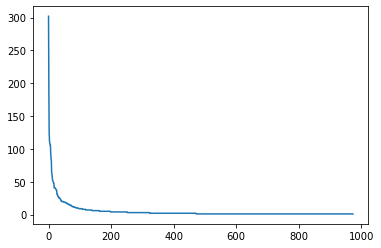

In [15]:
#Creating a figure and axis lets us do things like change the scaling or add a title
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
plt.show()

This shows that likelihood of a word occurring is inversely proportional to its rank. This effect is called [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law), and suggests that the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. Zipf's law is most easily observed by plotting the data on a log-log graph, with the axes being log (rank order) and log (frequency) resulting in a linear relationship.

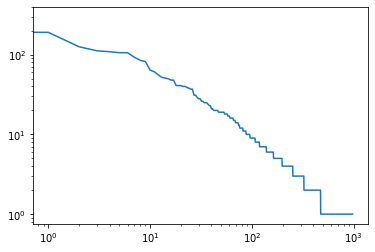

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

(The same relationship occurs in many other rankings, such as population ranks of cities, corporation sizes, income rankings, etc.)

The distribution was imagined by Zipf to be driven by a principle of 'least effort' where speakers did not work any harder than necessary to communicate a given idea, but the basis for this relationship is still not well understood and conforms at least as well to a process of [preferential attachment](https://en.wikipedia.org/wiki/Preferential_attachment) whereby people disproportionately attend to popular words.


# Getting and working with raw text

First, we will retrieve a collection of press releases from a *GitHub API* that archived them, based on a number of analyses by Justin Grimmer, a political scientist whose work we will read in two weeks!

GitHub API requests are made to `'https://api.github.com/'` and responses are in JSON, similar to Tumblr's API.

We will get the information on [github.com/lintool/GrimmerSenatePressReleases](https://github.com/lintool/GrimmerSenatePressReleases) as it contains a nice set documents.

In [17]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases')
senateReleasesData = json.loads(r.text)
print(senateReleasesData.keys())
print(senateReleasesData['description'])

dict_keys(['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'html_url', 'description', 'fork', 'url', 'forks_url', 'keys_url', 'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url', 'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url', 'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url', 'languages_url', 'stargazers_url', 'contributors_url', 'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url', 'comments_url', 'issue_comment_url', 'contents_url', 'compare_url', 'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url', 'milestones_url', 'notifications_url', 'labels_url', 'releases_url', 'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url', 'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size', 'stargazers_count', 'watchers_count', 'language', 'has_issues', 'has_projects', 'has_downloads', 'has_wiki', 'has_pages', 'has_discussions', 'forks_count', 'mirror_url', 'archived', 'disabled', 'open_

What we are interested in here is the `'contents_url'`

In [18]:
print(senateReleasesData['contents_url'])

https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/{+path}


We can use this to get any or all of the files from the repo.

In [19]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse')
whitehouseLinks = json.loads(r.text)
whitehouseLinks[0]

{'name': '10Apr2007Whitehouse123.txt',
 'path': 'raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'sha': 'f524289ee563dca58690c8d36c23dce5dbd9962a',
 'size': 2206,
 'url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
 'html_url': 'https://github.com/lintool/GrimmerSenatePressReleases/blob/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'git_url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
 'download_url': 'https://raw.githubusercontent.com/lintool/GrimmerSenatePressReleases/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'type': 'file',
 '_links': {'self': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
  'git': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
  'html': 'https:/

Now we have a list of information about Whitehouse press releases. Let's look at one of them.

In [20]:
r = requests.get(whitehouseLinks[0]['download_url'])
whitehouseRelease = r.text
print(whitehouseRelease[:1000])
len(whitehouseRelease)

SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY IN PUSH FOR STEM CELL RESEARCH
  Sharing the story of Lila Barber, a 12 year old girl from Westerly, Sen. Sheldon Whitehouse (D-R.I.) on Tuesday, April 10, 2007, illustrated the hope stem cell research can offer in a speech on the Senate floor in favor of legislation to expand federal funding for stem cell research.  
   Whitehouse met Lila two weeks ago. She was diagnosed two years ago with osteosarcoma, a cancerous bone condition, and last year underwent cadaver bone transplant surgery. The procedure saved her leg and is helping her remain cancer-free, but the transplanted tissue will not grow with her and likely will break down over time. Stem cell research, Whitehouse explained, could vastly improve the care of patients like Lila by allowing surgeons to enhance transplants with a patient's own stem cells, which could replace the lost bone and cartilage, or grow entirely new replacement bones and joints. 
   "Stem cell research gives hope

2206

Now we have a string of correctly encoded text. For analysis of its words, next we need to tokenize it, or split it into a sequence of tokens or word instances.

In [21]:
whTokens = word_tokenize(whitehouseRelease)
whTokens[10:30]

['STEM',
 'CELL',
 'RESEARCH',
 'Sharing',
 'the',
 'story',
 'of',
 'Lila',
 'Barber',
 'a',
 '12',
 'year',
 'old',
 'girl',
 'from',
 'Westerly',
 'Sen.',
 'Sheldon',
 'Whitehouse',
 'D']

Previous iterations of the course used `nltk`s tokenizer, but as we saw before, we used spaCy's model (https://spacy.io/api/tokenizer). We intend to avoid using NLTK when we can - for production level code, it is a lot faster and cleaner to use spaCy.

That being said, `nltk` does have some useful methods for quick analysis of small corpora. We will explore a few here, and encourage you to figure out for yourself which other ones might be useful.

To use the list of tokens in `nltk`, and take advantage of functions like `concordance`, shown above, we can convert it into a `Text`.

In [22]:
import nltk

In [23]:
whText = nltk.Text(whTokens)

whitehouseIndex = nltk.text.ConcordanceIndex(whText)
whitehouseIndex.print_concordance('Whitehouse')

Displaying 5 of 5 matches:
ld girl from Westerly Sen. Sheldon Whitehouse D R.I. on Tuesday April 10 2007 il
ral funding for stem cell research Whitehouse met Lila two weeks ago She was dia
 down over time Stem cell research Whitehouse explained could vastly improve the
s research might help or even cure Whitehouse said Whitehouse also praised the e
 help or even cure Whitehouse said Whitehouse also praised the efforts of Rhode 


*Note* that the `Text` class is for doing rapid, exploratory analysis. It provides an easy interface to many of the operations we want to do, but it does not allow us much control over the particular operations it glosses. When you are doing a more complete analysis, you should be using the module specifically designed for that task instead of the shortcut method `Text` provides, e.g. use  [`collocations` Module](http://www.nltk.org/api/nltk.html#module-nltk.collocations) instead of `.collocations()`.

Now that we have gotten this loaded, let's glance at few features we will delve into more deeply later.

For example, we can find words that statistically tend to occur together and typically have a composite, idiomatic meaning irreducible to the semantics of its component words. We will do this later with more control over exactly how these are identified.

Or we can pick a word (or words) and find what words tend to occur around it.

In [24]:
whText.common_contexts(['stem'])

for_cell on_cells the_cell hope_cell time_cell own_cells joints_cell
of_cell embryonic_cells


We can also just count the number of times the word occurs.

In [25]:
whText.count('cell')

5


We can also plot each time a set of words occurs.

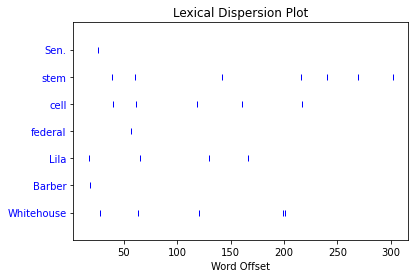

In [26]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['Sen.','stem', 'cell', 'federal' ,'Lila', 'Barber', 'Whitehouse'])
sns.set() #Re-enabling seaborn

If we want to do an analysis of all the Whitehouse press releases we will first need to obtain them. By looking at the API we can see the the URL we want is [https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse](https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse), so we can create a function to scrape the individual files.

If you want to know more about downloading from APIs, refer back to the 1st notebook.

In [27]:
def getGithubFiles(target, maxFiles = 100):
    #We are setting a max so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
        'path' : [], #The path in the git repo to the file
        'html_url' : [], #The url to see the file on Github
        'download_url' : [], #The url to download the file
    }

    #Get the directory information from Github
    r = requests.get(target)
    filesLst = json.loads(r.text)

    for fileDict in filesLst[:maxFiles]:
        #These are provided by the directory
        releasesDict['name'].append(fileDict['name'])
        releasesDict['path'].append(fileDict['path'])
        releasesDict['html_url'].append(fileDict['html_url'])
        releasesDict['download_url'].append(fileDict['download_url'])

        #We need to download the text though
        text = requests.get(fileDict['download_url']).text
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

whReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse', maxFiles = 10)
whReleases[:5]

,name,text,path,html_url,download_url
0,10Apr2007Whitehouse123.txt,SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...,raw/Whitehouse/10Apr2007Whitehouse123.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
1,10Apr2008Whitehouse2.txt,SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...,raw/Whitehouse/10Apr2008Whitehouse2.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
2,10Apr2008Whitehouse3.txt,EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...,raw/Whitehouse/10Apr2008Whitehouse3.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
3,10Aug2007Whitehouse78.txt,R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...,raw/Whitehouse/10Aug2007Whitehouse78.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
4,10Jan2008Whitehouse35.txt,SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...,raw/Whitehouse/10Jan2008Whitehouse35.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...


If you are having trouble downloading the data uncomment this next cell

In [28]:
#whReleases = pandas.read_csv('../data/whReleases.csv')

Now we have all the texts in a DataFrame we can look at a few things.

First let's tokenize the texts with the same tokenizer as we used before. We will just save the tokens as a list for now; no need to convert to `Text`s.

In [29]:
whReleases['tokenized_text'] = whReleases['text'].apply(lambda x: word_tokenize(x))

Now lets see how long each of the press releases is:

In [30]:
whReleases['word_counts'] = whReleases['tokenized_text'].apply(lambda x: len(x))
whReleases['word_counts']

0    350
1    311
2    497
3    189
4    236
5    334
6    241
7    469
8    443
9    425
Name: word_counts, dtype: int64

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that input and interrogate a corpus relating to your anticipated final project. This could include one of the Davies corpora or some other you have constructed. Turn your text into an nltk `Text` object, and explore all of the features examined above, and others that relate to better understanding your corpus in relation to your research question. </font>

My final project is to anlyze comments posted under news clips about the COVID-19 pandemic from 2020 to 2021. Specifically, given a popular YouTube news channel (ABC news in this case), I first generated a list of video links and randomly chose one each month. For each randomly selected video I scraped all of its comments and replies in the below github repo all in csv format. As demonstrated above I will use github API to collect these comments and preprocess them for later interrogation.

In [31]:
abc_comments_df = getGithubFiles('https://api.github.com/repos/yuzhouw313/MA_thesis/contents/youtube_comments/comments/abc_2020', maxFiles = 13)
abc_comments_df[:5]

,name,text,path,html_url,download_url
0,abc2001_comments.csv,"PublishedAt,Comment\r\n2020-09-11T20:09:00Z,I’...",youtube_comments/comments/abc_2020/abc2001_com...,https://github.com/yuzhouw313/MA_thesis/blob/m...,https://raw.githubusercontent.com/yuzhouw313/M...
1,abc2002_comments.csv,"PublishedAt,Comment\r\n2023-07-19T20:38:49Z,Je...",youtube_comments/comments/abc_2020/abc2002_com...,https://github.com/yuzhouw313/MA_thesis/blob/m...,https://raw.githubusercontent.com/yuzhouw313/M...
2,abc2003_comments.csv,"PublishedAt,Comment\r\n2022-03-27T16:35:52Z,👏\...",youtube_comments/comments/abc_2020/abc2003_com...,https://github.com/yuzhouw313/MA_thesis/blob/m...,https://raw.githubusercontent.com/yuzhouw313/M...
3,abc2004_comments.csv,"PublishedAt,Comment\r\n2020-04-10T04:42:59Z,""Q...",youtube_comments/comments/abc_2020/abc2004_com...,https://github.com/yuzhouw313/MA_thesis/blob/m...,https://raw.githubusercontent.com/yuzhouw313/M...
4,abc2005_comments.csv,"PublishedAt,Comment\r\n2020-09-21T23:47:03Z,""I...",youtube_comments/comments/abc_2020/abc2005_com...,https://github.com/yuzhouw313/MA_thesis/blob/m...,https://raw.githubusercontent.com/yuzhouw313/M...


In [32]:
# Now let's do some text preprocess
abc_comments_df['tokenized_text'] = abc_comments_df['text'].apply(lambda x: word_tokenize(x))
abc_comments_df[:5]

,name,text,path,html_url,download_url,tokenized_text
0,abc2001_comments.csv,"PublishedAt,Comment\r\n2020-09-11T20:09:00Z,I’...",youtube_comments/comments/abc_2020/abc2001_com...,https://github.com/yuzhouw313/MA_thesis/blob/m...,https://raw.githubusercontent.com/yuzhouw313/M...,"[PublishedAt, Comment, 2020, 09, 11T20:09:00Z,..."
1,abc2002_comments.csv,"PublishedAt,Comment\r\n2023-07-19T20:38:49Z,Je...",youtube_comments/comments/abc_2020/abc2002_com...,https://github.com/yuzhouw313/MA_thesis/blob/m...,https://raw.githubusercontent.com/yuzhouw313/M...,"[PublishedAt, Comment, 2023, 07, 19T20:38:49Z,..."
2,abc2003_comments.csv,"PublishedAt,Comment\r\n2022-03-27T16:35:52Z,👏\...",youtube_comments/comments/abc_2020/abc2003_com...,https://github.com/yuzhouw313/MA_thesis/blob/m...,https://raw.githubusercontent.com/yuzhouw313/M...,"[PublishedAt, Comment, 2022, 03, 27T16:35:52Z,..."
3,abc2004_comments.csv,"PublishedAt,Comment\r\n2020-04-10T04:42:59Z,""Q...",youtube_comments/comments/abc_2020/abc2004_com...,https://github.com/yuzhouw313/MA_thesis/blob/m...,https://raw.githubusercontent.com/yuzhouw313/M...,"[PublishedAt, Comment, 2020, 04, 10T04:42:59Z,..."
4,abc2005_comments.csv,"PublishedAt,Comment\r\n2020-09-21T23:47:03Z,""I...",youtube_comments/comments/abc_2020/abc2005_com...,https://github.com/yuzhouw313/MA_thesis/blob/m...,https://raw.githubusercontent.com/yuzhouw313/M...,"[PublishedAt, Comment, 2020, 09, 21T23:47:03Z,..."


In [33]:
# Next we see how word counts of comments change over the months
abc_comments_df['word_counts'] = abc_comments_df['tokenized_text'].apply(lambda x: len(x))
abc_comments_df['word_counts']

0     18248
1     35935
2     86439
3      5067
4      2256
5      1472
6     93854
7      6476
8      6602
9     84479
10     3798
11     5833
Name: word_counts, dtype: int64

Observation:
- Since the World Health Organization first discovered new cases of COVID-19 in Wuhan, China at December 31, 2019, it is not surprising that we see significant amount of comments, indicated by comments' tokens length. 
- The comment tokens' length continue to increase significantly in Feburary and March as CDC reported the first laboratory-confirmed case of the COVID-19 in the U.S at January 20.
- After the length of comments leveling off and continue to decrease, we see another peak in July, potentially due to the creation and introduction of COVID-19 vaccines announced by HHS at June 16.
- After 2 months of lower amount of comments, October saw another sharp increase, which might be triggered by President Trump tests positive for COVID-19.

Now let's turn Janurary's comments into nltk Text object to conduct further analysis:

In [34]:
jan_tokens = abc_comments_df.iloc[0]['tokenized_text']

In [35]:
jan_Text = nltk.Text(jan_tokens)

jan_Index = nltk.text.ConcordanceIndex(jan_Text)
jan_Index.print_concordance('China')

Displaying 25 of 85 matches:
4Z Depopulation 2020 02 02T01:10:40Z China now is a face mask nation 2020 02 01
 us who are US citizens have been to China every day most of everything we touc
ch in our homes and stores came from China If its a virus it could easily be sp
9Z Come one if anyone is coming from China to the U.S. they should land at a mi
round Because we do n’t fucking want China ’s fucking sickness going thru our c
spread And still letting planes from China to land on US soil without any restr
ions Warning people not to travel to China is meaningless if you are bringing p
,"I’m sorry but they need to stay in China Do n’t come back home and get you fa
the USA 2020 01 29T01:21:17Z What if China released the virus in order to gain 
16Z,"The true situation is here only China government doesn&#39;t admit!<br><a 
the people that made that product in China was sick and we ate that product tha
 It&#39;ll be to dang late just like China More info on what&#39;s going on het
7:36:05Z My

Observation:
- Since the pandemic was first discovered in China, it makes sense to see a lot of function words around "China" and discussion of the virus's origin such as "illnesses start in china."  
- While there are positive sentiments such as "My prayers go out to all in China", we mostly see concerns and hostility toward China demonstrated by "incoming tourists from China to infect...." or " What if China released the virus in order to gain"

In [36]:
# Let's take a look at what words are associating with China
jan_Text.common_contexts(['China'])

in_2020 in_is from_to in_< from_2020 to_to in_looks by_2020 in_you
>_wuhan 02t01:10:40z_now to_every from_if want_’s to_is in_do
if_released trust_incompetents only_government if_makes


Observation:
- "in_Wuhan": Suggests a geographic focus on the city of Wuhan which could be related to the initial outbreak of COVID-19 in Wuhan.
- "from_to": function words and might suggest discussions related to travelers from China to another concerning the spread of virus.
- "only_government": Could be indicative of content discussing government actions, policies, or responses in China or other countries in response to the outbreak.

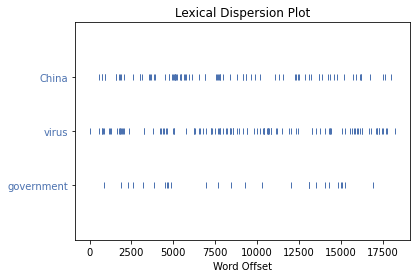

In [37]:
sns.reset_orig()
jan_Text.dispersion_plot(['China','virus', 'government'])
sns.set()

# Filtering and normalizing text

As we want to start comparing the different releases we may choose to do a bit of filtering and normalizing that will allow us to focus on what we most care about. We can first make all of the words lower case, then drop the non-word tokens. Next, we can remove some 'stop words', stem the remaining words to remove suffixes, prefixes and (in some languages) infixes, or lemmatize tokens by intelligently grouping inflected or variant forms of the same word (e.g., with a stemmer and a dictionary).

To begin this process, we will first define a function to work over the tokenized lists, then another to add normalized tokens to a new column.

We will be using spaCy's built in stop words identifying capacity. When we run text through spaCy's language pipeline, it automatically tags it as a stop word.

We can remove these stopwords from the analysis by fiat, but we could also take a more principled approach by looking at the frequency distribution of words and selecting a specific cut-off associated with the preservation of 'meaningful words' identified upon inspection. Alternatively, we could automatically set a cut-off by rule, such as removal of all words more frequent then the most frequent verb, or the most frequent noun (not pronoun), or some term of central interest.

In [38]:
countsDict = {}
for word in whReleases['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:20]

[('the', 179),
 ('of', 112),
 ('to', 112),
 ('and', 108),
 ('in', 64),
 ('a', 61),
 ("'s", 50),
 ('that', 41),
 ('our', 39),
 ('for', 35),
 ('on', 33),
 ('is', 33),
 ('Whitehouse', 31),
 ('Iraq', 28),
 ('Bush', 27),
 ('President', 25),
 ('troops', 21),
 ('by', 19),
 ('American', 19),
 ('with', 18)]

We can look at this and pick the cutoff, often at the first noun. So we will cut all words before `'Whitehouse'`.

In [39]:
#The stop list is then all words that occur before the first noun
stop_words_freq = []
for word, count in word_counts:
    if word == 'Whitehouse':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

['the', 'of', 'to', 'and', 'in', 'a', "'s", 'that', 'our', 'for', 'on', 'is']

If we did have any extra words to add as stop words apart from those normally considered as stop words, we would add it to our stop words by passing it to the normalize tokens method.

Now we can create our function to normalize the tokens

In [40]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list])

    doc = nlp(word_list.lower())

    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [41]:
whReleases['normalized_tokens'] = whReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

whReleases['normalized_tokens_count'] = whReleases['normalized_tokens'].apply(lambda x: len(x))

whReleases

,name,text,path,html_url,download_url,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count
0,10Apr2007Whitehouse123.txt,SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...,raw/Whitehouse/10Apr2007Whitehouse123.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, SHARES, WESTERLY, GIRL, 'S, ...",350,"[sen, whitehouse, share, westerly, girl, story...",224
1,10Apr2008Whitehouse2.txt,SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...,raw/Whitehouse/10Apr2008Whitehouse2.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, SAYS, PRESIDENT, BUSH, MUST,...",311,"[sen, whitehouse, say, president, bush, begin,...",159
2,10Apr2008Whitehouse3.txt,EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...,raw/Whitehouse/10Apr2008Whitehouse3.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[EPA, MUST, REVIEW, LEGAL, PROCESS, TO, ROOT, ...",497,"[epa, review, legal, process, root, political,...",298
3,10Aug2007Whitehouse78.txt,R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...,raw/Whitehouse/10Aug2007Whitehouse78.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[R.I., SENATORS, PRAISE, SEN, DENIAL, OF, LNG,...",189,"[r.i, senator, praise, sen, denial, lng, facil...",116
4,10Jan2008Whitehouse35.txt,SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...,raw/Whitehouse/10Jan2008Whitehouse35.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, COMMENTS, ON, ONE, YEAR, ANN...",236,"[sen, whitehouse, comment, year, anniversary, ...",125
5,10Mar2008Whitehouse8.txt,"SENS. REED, WHITEHOUSE WELCOME RHODE ISLAND ST...",raw/Whitehouse/10Mar2008Whitehouse8.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SENS, REED, WHITEHOUSE, WELCOME, RHODE, ISLAN...",334,"[sen, reed, whitehouse, welcome, rhode, island...",197
6,10Sep2007Whitehouse72.txt,REP. WHITEHOUSE ISSUES STATEMENT ON GEN. PETRA...,raw/Whitehouse/10Sep2007Whitehouse72.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[REP, WHITEHOUSE, ISSUES, STATEMENT, ON, GEN, ...",241,"[rep, whitehouse, issue, statement, gen, petra...",118
7,11Apr2007Whitehouse122.txt,SEN. WHITEHOUSE URGES BUSH FOR NEW DIRECTION I...,raw/Whitehouse/11Apr2007Whitehouse122.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, URGES, BUSH, FOR, NEW, DIREC...",469,"[sen, whitehouse, urge, bush, new, direction, ...",249
8,11Jan2007Whitehouse161.txt,"SENS. REED, WHITEHOUSE URGE PORTUGAL TO RECONS...",raw/Whitehouse/11Jan2007Whitehouse161.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SENS, REED, WHITEHOUSE, URGE, PORTUGAL, TO, R...",443,"[sen, reed, whitehouse, urge, portugal, recons...",237
9,11Mar2008Whitehouse7.txt,WHITEHOUSE UNVEILS 'BUSH DEBT': $7.7 TRILLION ...,raw/Whitehouse/11Mar2008Whitehouse7.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[WHITEHOUSE, UNVEILS, BUSH, DEBT, $, 7.7, TRIL...",425,"[whitehouse, unveil, bush, debt, $, foregone, ...",241


You can see that in the final step of normalizing, we add the lemmatized form of the word. spaCy's built in lemmatizer does this (https://spacy.io/api/lemmatizer). Lemmatization can be thought of as finding the root or the base of the word after removing inflections and other variations of words. Another possible way of finding the roots of words is using NLTK's porting or stemming functionalities, but we will not be getting into them.

Now that it is cleaned we start analyzing the dataset. We can start by finding frequency distributions for the dataset. Lets start looking at all the press releases together. The [`ConditionalFreqDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) class reads in an iterable of tuples, the first element is the condition and the second the focal word. For starters, we will use word lengths as the conditions, but tags or clusters will provide more useful results.

In [42]:
#.sum() adds together the lists from each row into a single list
whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in whReleases['normalized_tokens'].sum()))

#print the number of words
print(whcfdist.N())

1964


From this we can lookup the distributions of different word lengths

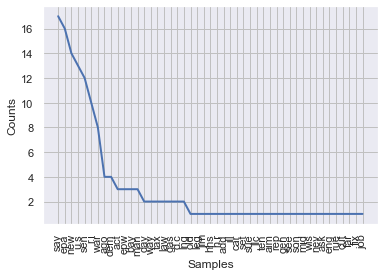

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [43]:
whcfdist[3].plot()

We can also create a Conditional Probability Distribution or [`ConditionalProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) from the `ConditionalFreqDist`. To do this, however, we need a model for the probability distribution. A simple model is [`ELEProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ELEProbDist) which gives the expected likelihood estimate for the probability distribution of the experiment used to generate the observed frequency distribution.

In [44]:
whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist)

#print the most common 2 letter word
print(whcpdist[2].max())

#And its probability
print(whcpdist[2].prob(whcpdist[2].max()))

ri
0.25


Length is one feature of a word, but there are many more important features we care about. Another critical feature is a word's role in the sentence, or its part of speech (POS).

The method below works similarly to ```nltk.pos_text```, and can work with the conditional frequency distributions it provides.

In [45]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [46]:
whReleases['normalized_tokens_POS'] = [spacy_pos(t) for t in whReleases['text']]

This gives us a new column with the part of speech as a short initialism and the word in a tuple, exactly how the `nltk.ConditionalFreqDist()` function wants them. We can now construct another conditional frequency distribution.

In [47]:
whcfdist_WordtoPOS = nltk.ConditionalFreqDist(whReleases['normalized_tokens_POS'].sum())
list(whcfdist_WordtoPOS.items())[:10]

[('sen', FreqDist({'NNP': 9})),
 ('.', FreqDist({'.': 126, 'NNP': 39, 'NN': 1})),
 ('whitehouse', FreqDist({'NN': 21, 'NNP': 19})),
 ('shares', FreqDist({'NNS': 1})),
 ('westerly', FreqDist({'RB': 2})),
 ('girl', FreqDist({'NN': 2})),
 ("'s", FreqDist({'POS': 47, 'VBZ': 5})),
 ('story', FreqDist({'NN': 2})),
 ('in', FreqDist({'IN': 72})),
 ('push', FreqDist({'NN': 1}))]

This gives the frequency of each word as each part of speech...which can be uninformative and boring. What we want is the converse; the frequency of each part of speech for each word.

In [48]:
whcfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in whReleases['normalized_tokens_POS'].sum())

We can now identify and collect all of the superlative adjectives

In [49]:
whcfdist_POStoWord['JJ']

FreqDist({'american': 17, 'new': 11, 'portuguese': 9, 'political': 8, 'federal': 6, 'clear': 5, 'general': 5, 'potential': 5, 'fiscal': 5, 'last': 4, ...})

Or look at the most common nouns

In [50]:
whcfdist_POStoWord['NN'].most_common(5)

[('whitehouse', 21),
 ('rhode', 19),
 ('island', 15),
 ('today', 15),
 ('stem', 12)]

Or plot the base form verbs against their number of occurrences

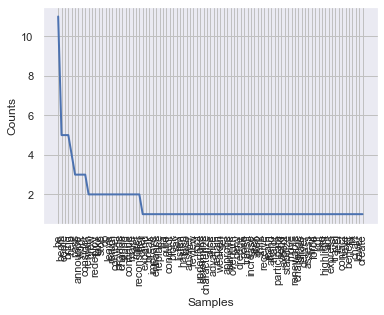

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [51]:
whcfdist_POStoWord['VB'].plot()

We can then do a similar analysis of the word probabilities

In [52]:
whcpdist_POStoWord = nltk.ConditionalProbDist(whcfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(whcpdist_POStoWord['NN'].max())

#And its probability
print(whcpdist_POStoWord['NN'].prob(whcpdist_POStoWord['NN'].max()))

whitehouse
0.025190392501464556


We can even create a...wait for it...*WORD CLOUD* or Wordl to gaze at and draw mystical, approximate inferences about important nouns and verbs in our corpus:

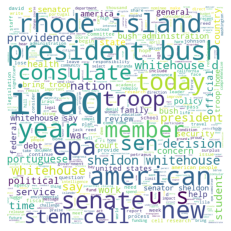

In [53]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(whReleases['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("whitehouse_word_cloud.pdf", format = 'pdf')

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that filter, stem and lemmatize the tokens in your corpus, and then creates plots (with titles and labels) that map the word frequency distribution, word probability distribution, and at least two conditional probability distributions that help us better understand the social and cultural game underlying the production of your corpus. Create a wordl of words (or normalized words) and add a few vague comments about what mysteries are revealed through it.</font>

### 1. Filter, stem, and lemmatize tokens in my corpos

In [61]:
countsDict = {}
for word in abc_comments_df['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:40]

[('2020', 11209),
 ('the', 11021),
 ('to', 7243),
 ('and', 6591),
 ('a', 5708),
 ('is', 5048),
 ('of', 4726),
 ('>', 4187),
 ('in', 3882),
 ('you', 3458),
 ('07', 3154),
 ('are', 3052),
 ('that', 2923),
 ('it', 2842),
 ('<', 2699),
 ('I', 2656),
 ('for', 2397),
 ('10', 2392),
 ('people', 2273),
 ('03', 2242),
 ('not', 2154),
 ('this', 1971),
 ('have', 1945),
 ('they', 1883),
 ('be', 1683),
 ('on', 1476),
 ('all', 1446),
 ('we', 1423),
 ('with', 1423),
 ('do', 1348),
 ('from', 1330),
 ('02', 1326),
 ('br', 1284),
 ('will', 1236),
 ('your', 1181),
 ('virus', 1092),
 ('about', 1078),
 ('or', 1070),
 ('as', 1050),
 ('but', 1044)]

In [62]:
stop_words_freq = []
for word, count in word_counts:
    if word == 'virus':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

['2020',
 'the',
 'to',
 'and',
 'a',
 'is',
 'of',
 '>',
 'in',
 'you',
 '07',
 'are',
 'that',
 'it',
 '<',
 'I',
 'for',
 '10',
 'people',
 '03',
 'not',
 'this',
 'have',
 'they',
 'be',
 'on',
 'all',
 'we',
 'with',
 'do',
 'from',
 '02',
 'br',
 'will',
 'your']

In [63]:
abc_comments_df['normalized_tokens'] = abc_comments_df['tokenized_text'].apply(lambda x: normalizeTokens(x))
abc_comments_df['normalized_tokens_count'] = abc_comments_df['normalized_tokens'].apply(lambda x: len(x))
abc_comments_df

,name,text,path,html_url,download_url,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count
0,abc2001_comments.csv,"PublishedAt,Comment\r\n2020-09-11T20:09:00Z,I’...",youtube_comments/comments/abc_2020/abc2001_com...,https://github.com/yuzhouw313/MA_thesis/blob/m...,https://raw.githubusercontent.com/yuzhouw313/M...,"[PublishedAt, Comment, 2020, 09, 11T20:09:00Z,...",18248,"[publishedat, comment, 11t20:09:00z, trump, ta...",8943
1,abc2002_comments.csv,"PublishedAt,Comment\r\n2023-07-19T20:38:49Z,Je...",youtube_comments/comments/abc_2020/abc2002_com...,https://github.com/yuzhouw313/MA_thesis/blob/m...,https://raw.githubusercontent.com/yuzhouw313/M...,"[PublishedAt, Comment, 2023, 07, 19T20:38:49Z,...",35935,"[publishedat, comment, 19t20:38:49z, jesus, ch...",17483
2,abc2003_comments.csv,"PublishedAt,Comment\r\n2022-03-27T16:35:52Z,👏\...",youtube_comments/comments/abc_2020/abc2003_com...,https://github.com/yuzhouw313/MA_thesis/blob/m...,https://raw.githubusercontent.com/yuzhouw313/M...,"[PublishedAt, Comment, 2022, 03, 27T16:35:52Z,...",86439,"[publishedat, comment, 27t16:35:52z, 👏, 11t14:...",42564
3,abc2004_comments.csv,"PublishedAt,Comment\r\n2020-04-10T04:42:59Z,""Q...",youtube_comments/comments/abc_2020/abc2004_com...,https://github.com/yuzhouw313/MA_thesis/blob/m...,https://raw.githubusercontent.com/yuzhouw313/M...,"[PublishedAt, Comment, 2020, 04, 10T04:42:59Z,...",5067,"[publishedat, comment, 10t04:42:59z,""queen, el...",2783
4,abc2005_comments.csv,"PublishedAt,Comment\r\n2020-09-21T23:47:03Z,""I...",youtube_comments/comments/abc_2020/abc2005_com...,https://github.com/yuzhouw313/MA_thesis/blob/m...,https://raw.githubusercontent.com/yuzhouw313/M...,"[PublishedAt, Comment, 2020, 09, 21T23:47:03Z,...",2256,"[publishedat, comment, 21t23:47:03z,""i, want, ...",1193
5,abc2006_comments.csv,"PublishedAt,Comment\r\n2021-07-19T00:46:14Z,I&...",youtube_comments/comments/abc_2020/abc2006_com...,https://github.com/yuzhouw313/MA_thesis/blob/m...,https://raw.githubusercontent.com/yuzhouw313/M...,"[PublishedAt, Comment, 2021, 07, 19T00:46:14Z,...",1472,"[publishedat, comment, 19t00:46:14z, i&#39;m, ...",760
6,abc2007_comments.csv,"PublishedAt,Comment\r\n2021-01-09T08:28:59Z,FA...",youtube_comments/comments/abc_2020/abc2007_com...,https://github.com/yuzhouw313/MA_thesis/blob/m...,https://raw.githubusercontent.com/yuzhouw313/M...,"[PublishedAt, Comment, 2021, 01, 09T08:28:59Z,...",93854,"[publishedat, comment, 09t08:28:59z, fake, new...",44089
7,abc2008_comments.csv,"PublishedAt,Comment\r\n2020-09-14T12:27:25Z,Do...",youtube_comments/comments/abc_2020/abc2008_com...,https://github.com/yuzhouw313/MA_thesis/blob/m...,https://raw.githubusercontent.com/yuzhouw313/M...,"[PublishedAt, Comment, 2020, 09, 14T12:27:25Z,...",6476,"[publishedat, comment, 14t12:27:25z, dope, vid...",3629
8,abc2009_comments.csv,"PublishedAt,Comment\r\n2023-04-10T07:38:56Z,wh...",youtube_comments/comments/abc_2020/abc2009_com...,https://github.com/yuzhouw313/MA_thesis/blob/m...,https://raw.githubusercontent.com/yuzhouw313/M...,"[PublishedAt, Comment, 2023, 04, 10T07:38:56Z,...",6602,"[publishedat, comment, 10t07:38:56z, threaten,...",3247
9,abc2010_comments.csv,"PublishedAt,Comment\r\n2023-09-18T15:53:23Z,Co...",youtube_comments/comments/abc_2020/abc2010_com...,https://github.com/yuzhouw313/MA_thesis/blob/m...,https://raw.githubusercontent.com/yuzhouw313/M...,"[PublishedAt, Comment, 2023, 09, 18T15:53:23Z,...",84479,"[publishedat, comment, 18t15:53:23z, compilati...",42111


In [64]:
abc_coments_cfdist = nltk.ConditionalFreqDist(((len(w), w) for w in abc_comments_df['normalized_tokens'].sum()))
print(abc_coments_cfdist.N())

171552


### 2. Word Frequency Distribution (Top 50)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(

/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127995 (\N{EMOJI MODIFIER FITZPATRICK TYPE-1-2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127997 (\N{EMOJI MODIFIER FITZPATRICK TYPE-4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48981 (\N{HANGUL SYLLABLE BBONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127996 (\N{E

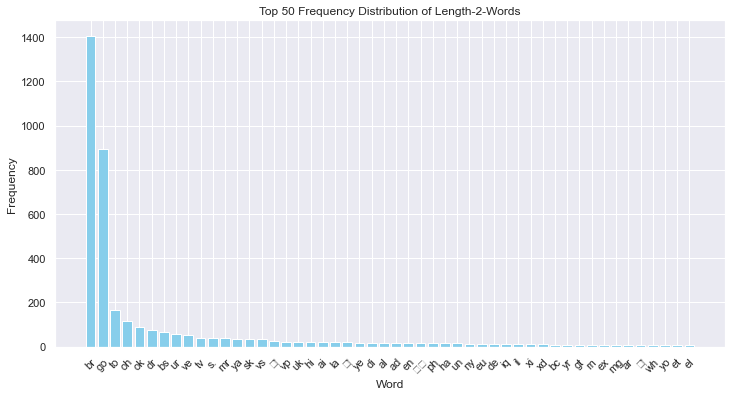

In [72]:
top_50_words = abc_coments_cfdist[2].most_common(50)
words, frequencies = zip(*top_50_words)

plt.figure(figsize=(12, 6))
plt.bar(words, frequencies, color='skyblue')
plt.title("Top 50 Frequency Distribution of Length-2-Words")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(

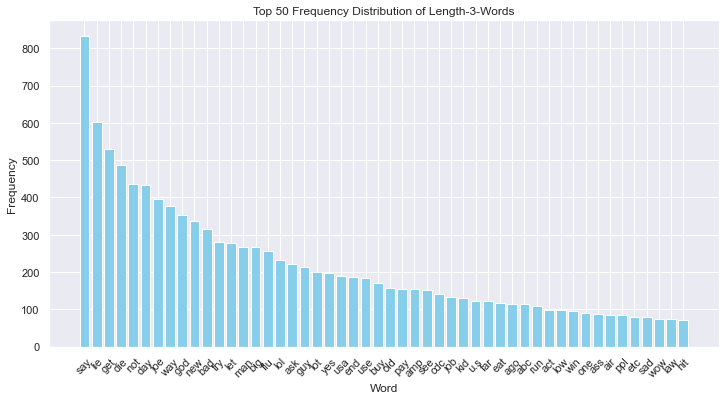

In [73]:
top_50_words = abc_coments_cfdist[3].most_common(50)
words, frequencies = zip(*top_50_words)

plt.figure(figsize=(12, 6))
plt.bar(words, frequencies, color='skyblue')
plt.title("Top 50 Frequency Distribution of Length-3-Words")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(

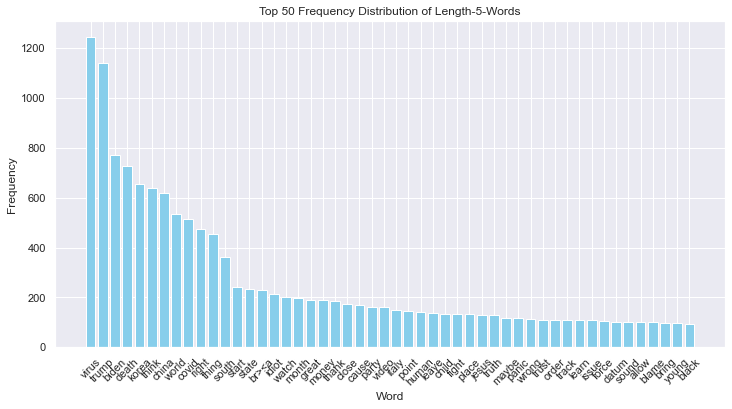

In [74]:
top_50_words = abc_coments_cfdist[5].most_common(50)
words, frequencies = zip(*top_50_words)

plt.figure(figsize=(12, 6))
plt.bar(words, frequencies, color='skyblue')
plt.title("Top 50 Frequency Distribution of Length-5-Words")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45)

- While the top 50 most frequent words of length 2 is not very informative, that of length 5 is informative.
- Pandemic disease related words 'virus', 'death', 'covid' are very frequent
- trump and biden are also frequent words here, which makes sense as 2020 is the election year and they might have political debate or policies regarding to the pandemic
- There are also negative words such as 'idiot', 'panic', 'blame' which might indicate the sentiment and people's attitude when watching the YouTube news on COVID-19

### 3. Word Probability Distribution (Top 100)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, 

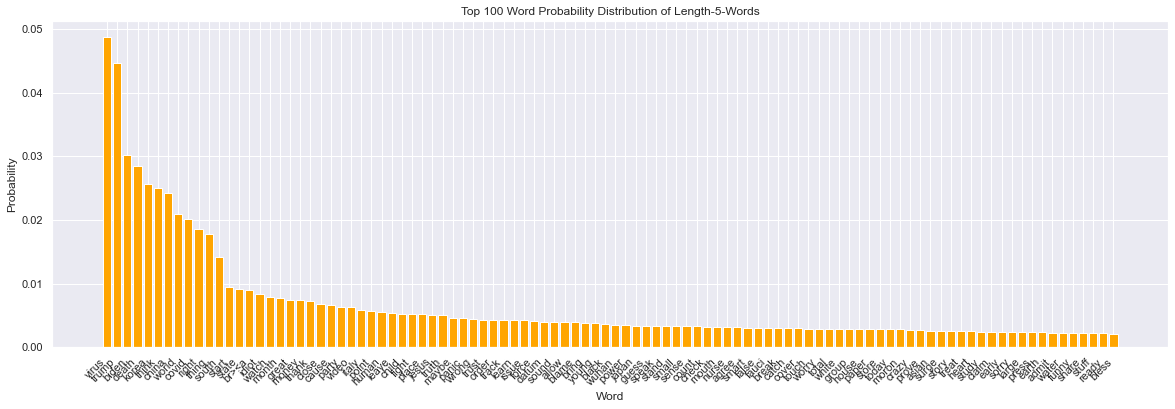

In [76]:
total_words = sum(abc_coments_cfdist[5].values())
probabilities = [count / total_words for count in abc_coments_cfdist[5].values()]

word_probabilities = list(zip(abc_coments_cfdist[5].keys(), probabilities))
word_probabilities.sort(key=lambda x: x[1], reverse=True)
top_words = [word for word, _ in word_probabilities[:100]]
top_probabilities = [prob for _, prob in word_probabilities[:100]]

plt.figure(figsize=(20, 6))
plt.bar(top_words, top_probabilities, color='orange')
plt.title("Top 100 Word Probability Distribution of Length-5-Words")
plt.xlabel("Word")
plt.ylabel("Probability")
plt.xticks(rotation=45, ha='right')

### 4. Conditional Probability Distributions

In [81]:
abc_comments_cpdist = nltk.ConditionalProbDist(abc_coments_cfdist, nltk.ELEProbDist)
print(abc_comments_cpdist[5].max())
print(abc_comments_cpdist[5].prob(abc_comments_cpdist[5].max()))

virus
0.047007982487592234


In [79]:
abc_comments_df['normalized_tokens_POS'] = [spacy_pos(t) for t in abc_comments_df['text']]
abc_comments_cfdist_WordtoPOS = nltk.ConditionalFreqDist(abc_comments_df['normalized_tokens_POS'].sum())
list(abc_comments_cfdist_WordtoPOS.items())[:10]

[('publishedat', FreqDist({'NNP': 12})),
 (',', FreqDist({',': 15005})),
 ('comment', FreqDist({'NN': 91, 'VB': 4, 'VBP': 2})),
 ('\r\n', FreqDist({'_SP': 11424})),
 ('2020', FreqDist({'CD': 11206})),
 ('-',
  FreqDist({'HYPH': 16987, 'SYM': 9371, 'CD': 391, ':': 147, 'JJ': 74, 'NN': 46, ',': 12, 'NNP': 12, 'NNS': 10, 'VBN': 4, ...})),
 ('09', FreqDist({'CD': 242})),
 ('11t20:09:00z', FreqDist({'CD': 1})),
 ('i’m', FreqDist({'NNP': 27, 'JJ': 1})),
 ('here', FreqDist({'RB': 390, 'JJ': 1}))]

In [83]:
abc_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in abc_comments_df['normalized_tokens_POS'].sum())
abc_POStoWord['JJ']

FreqDist({'other': 485, 'many': 454, 'good': 351, 'covid': 351, 'new': 285, 'fake': 244, 'sick': 242, 'korean': 233, 'same': 219, 'stupid': 219, ...})

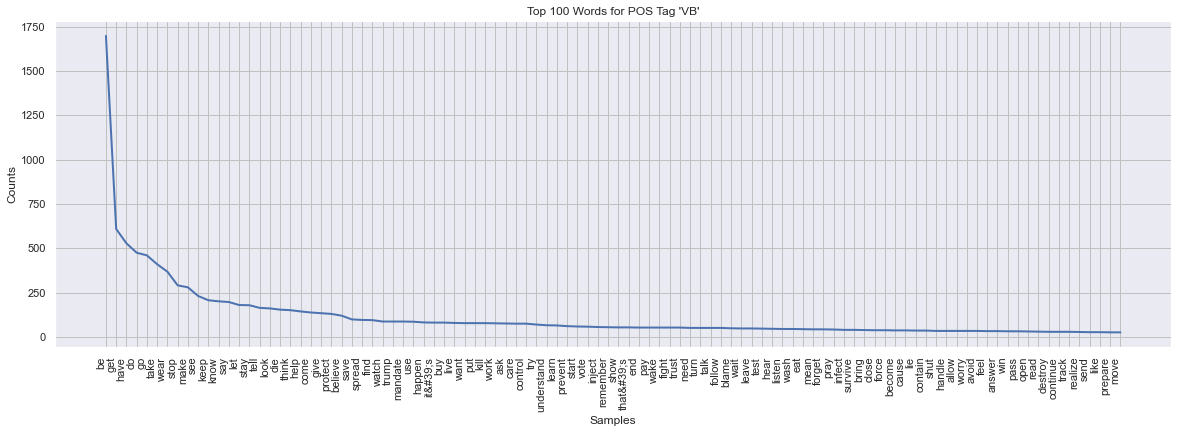

<AxesSubplot:title={'center':"Top 100 Words for POS Tag 'VB'"}, xlabel='Samples', ylabel='Counts'>

In [89]:
plt.figure(figsize=(20, 6))
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
abc_POStoWord['VB'].plot(100, title="Top 100 Words for POS Tag 'VB'")


/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


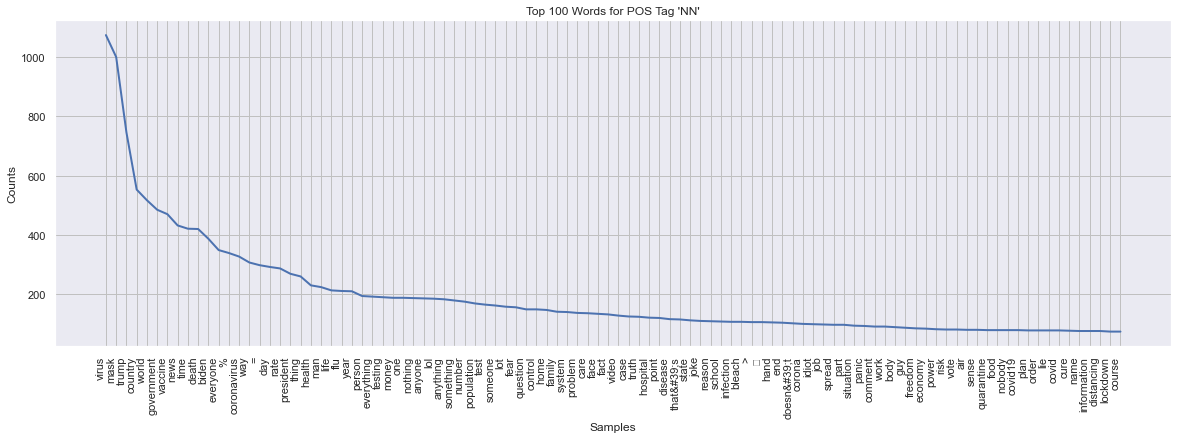

<AxesSubplot:title={'center':"Top 100 Words for POS Tag 'NN'"}, xlabel='Samples', ylabel='Counts'>

In [90]:
plt.figure(figsize=(20, 6))
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
abc_POStoWord['NN'].plot(100, title="Top 100 Words for POS Tag 'NN'")

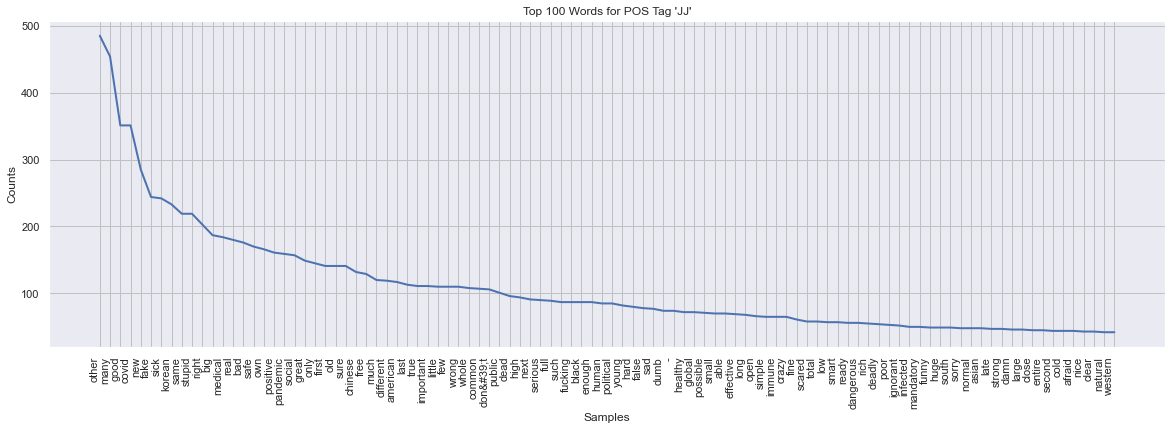

<AxesSubplot:title={'center':"Top 100 Words for POS Tag 'JJ'"}, xlabel='Samples', ylabel='Counts'>

In [91]:
plt.figure(figsize=(20, 6))
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
abc_POStoWord['JJ'].plot(100, title="Top 100 Words for POS Tag 'JJ'")

### 5. Word Cloud

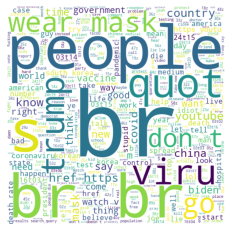

In [92]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(abc_comments_df['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("abc_news_word_cloud.pdf", format = 'pdf')

Observation:
- One conspicuous word here is "br", though I am not sure how to interpret this finding at this stage
- We see other frequent words closely related to the pandemic such as "virus", "wear" and "mask"
- We also see the prevalence of countries, policies, and governments: "country", "government", "china", "america", "state" which indidates the heated discussions on between-counties tension, domestic policies.

## Davies Corpora

Now that we have our basic cleaning down, we can arrange our Davies Corpora. Let us try this with the movies corpora we have already loaded.

We'll use a smaller corpus of a 1000 movies for this demonstration.

In [93]:
zfile = zipfile.ZipFile(corpus_name + "/sources_movies.zip")
source = []

In [94]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [95]:
source[0:20]

[b'textID\tfileID\t#words\tgenre\tyear\tlanguage(s)\tcountry\timdb\ttitle\r\n',
 b'-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\r\n',
 b'\r\n',
 b'290635\t3547424\t4722\tShort, Musical\t1930\tUK\tEnglish\t0290635\tGoodbye to All That\r\n',
 b'21165\t6332374\t10220\tCrime, Mystery, Thriller\t1930\tUK\tEnglish\t0021165\tMurder!\r\n',
 b'21191\t6013789\t5281\tDrama, Romance\t1930\tUSA\tEnglish\t0021191\tA Notorious Affair\r\n',
 b'20620\t3660608\t6724\tBiography, Drama, History\t1930\tUSA\tEnglish\t0020620\tAbraham Lincoln\r\n',
 b'20629\t60053\t9552\tDrama, War\t1930\tUSA\tEnglish, French, German, Latin\t0020629\tAll Quiet on the Western Front\r\n',
 b'20640\t6850720\t13862\tComedy, Musical\t1930\tUSA\tEnglish\t0020640\tAnimal Crackers\r\n',
 b'20641\t176501\t11140\tDrama, Romance\t1930\tUSA\tEnglish\t0020641\tAnna Christie\r\n',
 b'20643\t3603861\t1748\tComedy, Short\t1930\tUSA\tEnglish\t0020643\tAnother Fine Mess\r\n',
 b'20670\t4159455\t6966\tComedy, Musical\t1930\tUS

It looks dirty because the file is encoded as bytes, but we can certainly see the information there. The file id is also present in the original raw text data: as the first "word". Look back at the normalized/tokenized words to confirm that. We're going to use this to create a dataframe with: Fileid, movie name, genre, year, and country.

It is advised that you run a similar check of the source file before you do other extraction.

First, let us create a dictionary mapping file-id to all the text. Each movie will be mapped to a list of the tokenized words.

In this example, I only use it to load 100 movies. You can comment this out or increase/decrease the number as you see fit.

Note that in the following cells, we make use of the `lucem_illud` package's `word_tokenize` function. You can see that function on line 70 of [processing.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/processing.py), and we provide the code here for transparency. Since we put this folder in our helper package, you won't need to define this function every time you want to use it; you just `import lucem_illud`!

In [96]:
# processing.py calls a spacy model called "en" (and sometimes called "en_core_web_sm") so we load that first.
try:
    nlp = spacy.load("en")
except OSError:
    nlp = spacy.load("en_core_web_sm")


#Here is the function from lucem_illud/lucem_illud/processing.py
def word_tokenize(word_list, model=nlp, MAX_LEN=1500000):

    tokenized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list])
    # since we're only tokenizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list, disable=["parser", "tagger", "ner"])

    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [97]:
movie_texts = {}

In [99]:
for files in movie_raw:
    if len(movie_texts) > 100:
        break
    movies = clean_raw_text(movie_raw[files][1:])
    for movie in movies:
        # We can run the following line of code with or without `lucem_illud.`, using the package or our code 2 cells above.
        txts = lucem_illud.word_tokenize(movie)
        try:
            movie_texts[txts[0][2:]] = txts[1:]
        except IndexError:
            continue

In [100]:
import pandas as pd

In [101]:
movie_df = pd.DataFrame(columns=["Movie Name", "Genre", "Year", "Country", "Tokenized Texts"])

In [102]:
for movie in source[3:]:
    try:
        tid, fileid, total_words, genre, year, lang, country, imdb, title = movie.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    try:
        movie_df.loc[fileid.strip()] = [title.strip(), genre.strip(), year.strip(), country.strip(), movie_texts[fileid.strip()]]
    except KeyError:
        continue

In [103]:
movie_df.head()

,Movie Name,Genre,Year,Country,Tokenized Texts
6850720,Animal Crackers,"Comedy, Musical",1930,English,"[You, must, do, your, best, tonight, Be, on, y..."
176501,Anna Christie,"Drama, Romance",1930,English,"[Either, you, 're, flat, or, I, am, I, beg, yo..."
4056770,Ladies of Leisure,"Drama, Romance",1930,English,"[Look, out, There, 's, another, bottle, coming..."
5992934,Over the Hill,Drama,1931,English,"[Good, morning, kitty, Come, in, here, baby, I..."
4436137,Design for Living,"Comedy, Romance",1933,"English, French","[Train_engine_grinding, 26;1426;TOOLONG, Whist..."


# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. We will be using the in-built spaCy pos-tagging.

https://spacy.io/usage/linguistic-features

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

spaCy pos-tags word as we run it through the english language model. A small example:

In [104]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")


In [106]:
for token in sent:
    print(token.text, token.pos_, token.tag_)

Tom PROPN NNP
went VERB VBD
to ADP IN
IKEA NOUN NN
to PART TO
get VERB VB
some PRON DT
of ADP IN
those DET DT
delicious ADJ JJ
Swedish ADJ JJ
meatballs NOUN NNS
. PUNCT .


This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [111]:
redditDF = pandas.read_csv('/Users/itsyuzhou/Winter2024/Content-Analysis-Homework/notebooks/week2/reddit.csv')


Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word). Here, we will use sentences tokenized by spaCy. Like before, these methods can also be found in `lucem_illud`.



In [112]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences

In [113]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores

/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


,Unnamed: 0,author,over_18,score,subreddit,text,title,url,sentences
9,8,brenkelieshere,False,9448,Tales From Tech Support,"Last year, Help Desk got a call from a user co...",How to fix a laptop that won't boot in under a...,https://www.reddit.com/r/talesfromtechsupport/...,"[[Last, year, Help, Desk, got, a, call, from, ..."
8,7,Bombadils,False,10528,Tales From Tech Support,First post in quite some time! I work at a loc...,"OK, now the password is 'D35p41r'",https://www.reddit.com/r/talesfromtechsupport/...,"[[First, post, in, quite, some, time], [I, wor..."
7,1200,whenlifegivesyoushit,False,11003,Relationships,[Original Post](https://www.reddit.com/r/relat...,[UPDATE]My [26 F] with my husband [29 M] 1 yea...,https://www.reddit.com/r/relationships/comment...,"[[Original, Post](https://www.reddit.com, r, r..."
6,6,sfsdfd,False,11295,Tales From Tech Support,I witnessed this astounding IT meltdown around...,"Company-wide email + 30,000 employees + auto-r...",https://www.reddit.com/r/talesfromtechsupport/...,"[[I, witnessed, this, astounding, IT, meltdown..."
5,5,Raitaro,False,12372,Tales From Tech Support,I work Helpdesk for a retail store chain in th...,I'm pretty sure I knocked a user out from near...,https://www.reddit.com/r/talesfromtechsupport/...,"[[I, work, Helpdesk, for, a, retail, store, ch..."
4,4,goldie-gold,False,12650,Tales From Tech Support,"This just happened... So, I had a laptop syst...",Engineer is doing drugs!! No. No they aren't.,https://www.reddit.com/r/talesfromtechsupport/...,"[[This, just, happened], [So, I, had, a, lapto..."
3,3,TheDroolinFool,False,13152,Tales From Tech Support,Another tale from the out of hours IT desk... ...,"""I need you to fix Google Bing immediately!""",https://www.reddit.com/r/talesfromtechsupport/...,"[[Another, tale, from, the, out, of, hours, IT..."
2,2,Clickity_clickity,False,13404,Tales From Tech Support,[Part 1](http://www.reddit.com/r/talesfromtech...,"Jack, the Worst End User, Part 4",https://www.reddit.com/r/talesfromtechsupport/...,"[[Part, 1](http://www.reddit.com, r, talesfrom..."
1,1,SECGaz,False,13724,Tales From Tech Support,"> $Me - Hello, IT. > $Usr - Hi, I am still ...","Hi, I am still off sick but I am not.",https://www.reddit.com/r/talesfromtechsupport/...,"[[>, $, Me, Hello, IT], [>, $, Usr, Hi, I, am,..."
0,0,guitarsdontdance,False,14089,Tales From Tech Support,So my story starts on what was a normal day ta...,"""Don't bother sending a tech, I'll be dead by ...",https://www.reddit.com/r/talesfromtechsupport/...,"[[So, my, story, starts, on, what, was, a, nor..."


In [116]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)

    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)

    return pos_sents

In [117]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_pos(x))

In [118]:
redditTopScores['POS_sents']

9    [[(Last, JJ), (year, NN), (Help, NNP), (Desk, ...
8    [[(First, JJ), (post, NN), (in, IN), (quite, P...
7    [[(Original, JJ), (Post](https://www.reddit.co...
6    [[(I, PRP), (witnessed, VBD), (this, DT), (ast...
5    [[(I, PRP), (work, VBP), (Helpdesk, NNP), (for...
4    [[(This, DT), (just, RB), (happened, VBD), (So...
3    [[(Another, DT), (tale, NN), (from, IN), (the,...
2    [[(Part, NN), (1](http://www.reddit.com, NNP),...
1    [[(>, XX), ($, $), (Me, PRP)], [(Hello, UH), (...
0    [[(So, RB), (my, PRP$), (story, NN), (starts, ...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [119]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('password', 22),
 ('time', 14),
 ('computer', 13),
 ('lot', 12),
 ('life', 11),
 ('email', 11),
 ('system', 10),
 ('laptop', 9),
 ('message', 9),
 ('day', 9),
 ('auto', 9),
 ('call', 8),
 ('office', 8),
 ('part', 8),
 ('today', 8),
 ('story', 8),
 ('job', 7),
 ('something', 7),
 ('problem', 7),
 ('drawer', 7)]

What about the adjectives that modify the word, "computer"?

In [120]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'unrestricted', 'own'}


## <font color="red">Exercise 3</font>

<font color="red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional associations (e.g., adjectives associated with nouns or adverbs with verbs of interest). What do these distributions suggest about your corpus?

In [124]:
abc_comments_df.head()

,name,text,path,html_url,download_url,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count,normalized_tokens_POS
0,abc2001_comments.csv,"PublishedAt,Comment\r\n2020-09-11T20:09:00Z,I’...",youtube_comments/comments/abc_2020/abc2001_com...,https://github.com/yuzhouw313/MA_thesis/blob/m...,https://raw.githubusercontent.com/yuzhouw313/M...,"[PublishedAt, Comment, 2020, 09, 11T20:09:00Z,...",18248,"[publishedat, comment, 11t20:09:00z, trump, ta...",8943,"[(publishedat, NNP), (,, ,), (comment, NN), (\..."
1,abc2002_comments.csv,"PublishedAt,Comment\r\n2023-07-19T20:38:49Z,Je...",youtube_comments/comments/abc_2020/abc2002_com...,https://github.com/yuzhouw313/MA_thesis/blob/m...,https://raw.githubusercontent.com/yuzhouw313/M...,"[PublishedAt, Comment, 2023, 07, 19T20:38:49Z,...",35935,"[publishedat, comment, 19t20:38:49z, jesus, ch...",17483,"[(publishedat, NNP), (,, ,), (comment, NN), (\..."
2,abc2003_comments.csv,"PublishedAt,Comment\r\n2022-03-27T16:35:52Z,👏\...",youtube_comments/comments/abc_2020/abc2003_com...,https://github.com/yuzhouw313/MA_thesis/blob/m...,https://raw.githubusercontent.com/yuzhouw313/M...,"[PublishedAt, Comment, 2022, 03, 27T16:35:52Z,...",86439,"[publishedat, comment, 27t16:35:52z, 👏, 11t14:...",42564,"[(publishedat, NNP), (,, ,), (comment, NN), (\..."
3,abc2004_comments.csv,"PublishedAt,Comment\r\n2020-04-10T04:42:59Z,""Q...",youtube_comments/comments/abc_2020/abc2004_com...,https://github.com/yuzhouw313/MA_thesis/blob/m...,https://raw.githubusercontent.com/yuzhouw313/M...,"[PublishedAt, Comment, 2020, 04, 10T04:42:59Z,...",5067,"[publishedat, comment, 10t04:42:59z,""queen, el...",2783,"[(publishedat, NNP), (,, ,), (comment, NN), (\..."
4,abc2005_comments.csv,"PublishedAt,Comment\r\n2020-09-21T23:47:03Z,""I...",youtube_comments/comments/abc_2020/abc2005_com...,https://github.com/yuzhouw313/MA_thesis/blob/m...,https://raw.githubusercontent.com/yuzhouw313/M...,"[PublishedAt, Comment, 2020, 09, 21T23:47:03Z,...",2256,"[publishedat, comment, 21t23:47:03z,""i, want, ...",1193,"[(publishedat, NNP), (,, ,), (comment, NN), (\..."


In [127]:
abc_comments_df['normalized_tokens_POS'].iloc[1]

[('publishedat', 'NNP'),
 (',', ','),
 ('comment', 'NN'),
 ('\r\n', '_SP'),
 ('2023', 'CD'),
 ('-', 'SYM'),
 ('07', 'CD'),
 ('-', 'HYPH'),
 ('19t20:38:49z', 'CD'),
 (',', ','),
 ('jesus', 'NNP'),
 ('christ', 'NNP'),
 ('himself', 'PRP'),
 ('told', 'VBD'),
 ('a', 'DT'),
 ('visionarie', 'NN'),
 ('eat', 'VB'),
 ('moringa', 'NN'),
 ('leaf&#39;s', 'NNS'),
 ('against', 'IN'),
 ('the', 'DT'),
 ('viruses', 'NNS'),
 ('it', 'PRP'),
 ('builds', 'VBZ'),
 ('up', 'RP'),
 ('the', 'DT'),
 ('immune', 'JJ'),
 ('system', 'NN'),
 ('against', 'IN'),
 ('the', 'DT'),
 ('viruses', 'NNS'),
 ('\r\n', '_SP'),
 ('2020', 'CD'),
 ('-', 'HYPH'),
 ('08', 'CD'),
 ('-', 'HYPH'),
 ('13t09:49:16z', 'CD'),
 (',', ','),
 ('in', 'IN'),
 ('our', 'PRP$'),
 ('small', 'JJ'),
 ('state', 'NN'),
 ('no', 'DT'),
 ('corona', 'NN'),
 ('no', 'DT'),
 ('mask', 'NN'),
 ('.', '.'),
 ('amen', 'UH'),
 ('\r\n', '_SP'),
 ('2020', 'CD'),
 ('-', 'SYM'),
 ('06', 'CD'),
 ('-', 'HYPH'),
 ('11t21:50:45z', 'CD'),
 (',', ','),
 ('you', 'PRP'),
 ('reali

In [130]:
# 1. Examine the top 30 words of POS tag NN
countTarget = 'NN'
targetCounts = {}

for row in abc_comments_df['normalized_tokens_POS']:
    for token, tag in row:
        if tag != countTarget:
            continue
        elif token in targetCounts:
            targetCounts[token] += 1
        else:
            targetCounts[token] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:30]

[('virus', 1074),
 ('mask', 1000),
 ('trump', 746),
 ('country', 553),
 ('world', 517),
 ('government', 485),
 ('vaccine', 470),
 ('news', 432),
 ('time', 421),
 ('death', 420),
 ('biden', 387),
 ('everyone', 349),
 ('%', 339),
 ('coronavirus', 327),
 ('way', 307),
 ('=', 298),
 ('day', 292),
 ('rate', 287),
 ('president', 269),
 ('thing', 260),
 ('health', 230),
 ('man', 224),
 ('life', 213),
 ('flu', 211),
 ('year', 210),
 ('person', 194),
 ('everything', 192),
 ('testing', 190),
 ('money', 188),
 ('one', 188)]

Observations:
- Keywords Related to the Pandemic: 'virus', 'mask', 'coronavirus', 'flu,' etc are directly related to the COVID-19 pandemic, reflecting discussions about the virus, preventive measures (e.g., masks), and comparisons with other illnesses (e.g., flu).
- Political Figures and Issues: political figures ('trump' and 'biden') suggests that discussions include political aspects related to the pandemic; 'government' and 'president' reflect discussions about governance and leadership during the crisis.
- Global Impact and Concerns: 'country', 'world': Reflects concerns about the global impact of the pandemic and discussions about its effects on different countries.
- Medical and Health Themes: 'vaccine', 'death', 'health', 'testing' indicate discussions related to medical aspects of the pandemic, including vaccine development, mortality ('death'), public health ('health'), and testing for the virus.

In [131]:
# 2. Examine the top 30 words of POS tag VB
countTarget = 'VB'
targetCounts = {}

for row in abc_comments_df['normalized_tokens_POS']:
    for token, tag in row:
        if tag != countTarget:
            continue
        elif token in targetCounts:
            targetCounts[token] += 1
        else:
            targetCounts[token] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:30]

[('be', 1698),
 ('get', 609),
 ('have', 528),
 ('do', 475),
 ('go', 460),
 ('take', 410),
 ('wear', 368),
 ('stop', 291),
 ('make', 280),
 ('see', 231),
 ('keep', 207),
 ('know', 201),
 ('say', 197),
 ('let', 180),
 ('stay', 179),
 ('tell', 164),
 ('look', 161),
 ('die', 154),
 ('think', 151),
 ('help', 144),
 ('come', 138),
 ('give', 134),
 ('protect', 130),
 ('believe', 120),
 ('save', 99),
 ('spread', 96),
 ('find', 95),
 ('watch', 87),
 ('trump', 87),
 ('mandate', 87)]

Observations:
- Health-Related Verbs: 'wear', 'stop', 'protect', 'spread', 'mandate' reflects discussions related to health measures, protective actions, and the spreading of the virus.
- Political and Controversial Verbs: 'say', 'believe', 'trump', 'mandate' suggests that discussions involve statements, beliefs, and controversial figures (e.g., 'trump' and 'mandate').
- Crisis Management Verbs: 'help', 'save' reflects verbs associated with crisis response and efforts to assist or save lives.

In [132]:
# 3. Examine the top 30 words of POS tag JJ
countTarget = 'JJ'
targetCounts = {}

for row in abc_comments_df['normalized_tokens_POS']:
    for token, tag in row:
        if tag != countTarget:
            continue
        elif token in targetCounts:
            targetCounts[token] += 1
        else:
            targetCounts[token] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:30]

[('other', 485),
 ('many', 454),
 ('good', 351),
 ('covid', 351),
 ('new', 285),
 ('fake', 244),
 ('sick', 242),
 ('korean', 233),
 ('same', 219),
 ('stupid', 219),
 ('right', 203),
 ('big', 187),
 ('medical', 184),
 ('real', 180),
 ('bad', 176),
 ('safe', 170),
 ('own', 166),
 ('positive', 161),
 ('pandemic', 159),
 ('social', 157),
 ('great', 149),
 ('only', 145),
 ('first', 141),
 ('old', 141),
 ('sure', 141),
 ('chinese', 132),
 ('free', 129),
 ('much', 120),
 ('different', 119),
 ('american', 117)]

Observation:
- To my surprise, the occurrence of chinese is not that frequent, considering the presumption that people associate covid with chinese. Interestingly, korean ranked very high among other adjectives.
- Negative adjectives ('fake', 'stupid', 'bad') suggest criticism or unfavorable opinions, possibly related to misinformation, perceived inadequacies, or negative experiences.
- Overall, analyzing JJ tokens provides a nuanced understanding of the sentiments and characteristics associated with different aspects of COVID-19 discussions. The mix of positive and negative adjectives reflects the diverse range of opinions and experiences within the online discourse, which makes sense as our source is abc news which is relatively neutral, instead of extremely conservative or liberal.

In [136]:
# 4. Examine the words of POS tag VB associated with covid
NTarget = 'VB'
Word = 'covid'
NResults = set()

for sentence in abc_comments_df['normalized_tokens_POS']:
    for (ent1, kind1), (ent2, kind2) in zip(sentence[:-1], sentence[1:]):
        if (kind1, ent2.lower()) == (NTarget, Word):
            NResults.add(ent1)
        else:
            continue

print(NResults)

{'defeat', 'get', 'let', 'stop', 'shed', 'make', 'list', 'spread', 'bring', 'hve', 'carry', 'control', 'kill', 'take', 'receive', 'recover'}


Observations:
- Not surprisngly we see a lot of action verbs indicating the control and termination of covid, such as 'control', 'defeat', 'stop', 'kill' which might contribute to a positive sentiment of rallying together to stop the pandemic
- We also see words indicating the spread of virus, such as 'get', 'spread', 'bring', 'carry', which might suggest a fear of catching or spreading of the virus
- We also see there is a misspelling of 'hve' which should be 'have'

In [137]:
# 5. Examine the words of POS tag VB associated with china
NTarget = 'VB'
Word = 'china'
NResults = set()

for sentence in abc_comments_df['normalized_tokens_POS']:
    for (ent1, kind1), (ent2, kind2) in zip(sentence[:-1], sentence[1:]):
        if (kind1, ent2.lower()) == (NTarget, Word):
            NResults.add(ent1)
        else:
            continue

print(NResults)

{'want', 'punish', 'depopulate', 'believe', 'make', 'leave', 'convert', 'address', 'murder', 'ban', 'nuke', 'fight', 'let', 'save', 'sue', 'hate', 'conquer', 'blame', 'investigate'}


Observations:
- While based on the analysis of NN we see 'china' is not as frequent as expected, we see a largely negative sentiment revolving around 'china' by looking into verbs associated with it.
- We see a lot of verbs that focus on punishing china, such as 'punish', 'depopulate', 'murder', 'ban', 'fight', 'hate', 'conquer', 'blame'
- Also see one positive verb of 'save'
- Since China is believed to be the origin of the pandemic, we see verbs associated with the investigation such as 'investigate'

# Collocations

As illustrated above, we might want to find significant bigrams (two-word phrases), trigrams (three-word phrases), n-grams (*n*-word phrases) or skip-grams (noncontinguous 'phrases' with skip-length *n*).

We will begin with the [`nltk.collocations.BigramCollocationFinder`](http://www.nltk.org/api/nltk.html?highlight=bigramcollocationfinder#nltk.collocations.BigramCollocationFinder) class, which can be given raw lists of strings with the `from_words()` method. By default it only looks at continuous bigrams but there is an option (`window_size`) to allow skip-grams.

In [138]:
whBigrams = nltk.collocations.BigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(whBigrams.N))

There are 1964 bigrams in the finder


To compare the bigrams we need to tell nltk what our score function is. Initially, we will look at the raw counts.

In [139]:
def bigramScoring(count, wordsTuple, total):
    return count

print(whBigrams.nbest(bigramScoring, 10))

[('president', 'bush'), ('rhode', 'island'), ('sheldon', 'whitehouse'), ('stem', 'cell'), ('whitehouse', 'd'), ('d', 'r.i'), ('bush', 'administration'), ('u.s', 'senator'), ('whitehouse', 'say'), ('american', 'people')]


One note about how `BigramCollocationFinder` works. It doesn't use the strings internally.

In [140]:
birgramScores = []

def bigramPrinting(count, wordsTuple, total):
    global birgramScores
    birgramScores.append("The first word is:  {}, The second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

whBigrams.nbest(bigramPrinting, 10)
print('\n'.join(birgramScores[:10]))

The first word is:  28, The second word is: 31
The first word is:  20, The second word is: 17
The first word is:  12, The second word is: 12
The first word is:  12, The second word is: 40
The first word is:  40, The second word is: 17
The first word is:  17, The second word is: 10
The first word is:  40, The second word is: 17
The first word is:  13, The second word is: 13
The first word is:  31, The second word is: 11
The first word is:  9, The second word is: 24


The words are each given numeric IDs and there is a dictionary that maps the IDs to the words they represent. This is a common performance optimization.

Two words can appear together by chance. Recall from  Manning and Schütze's textbook that a t-value can be computed for each bigram to see how significant the association is. You may also want to try computing the $\chi^2$, likelihood ratio, and pointwise mutual information statistics.

In [141]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
whBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]
# other options include student_t, chi_sq, likelihood_ratio, pmi

[(('rhode', 'island'), 178.42791632631025),
 (('stem', 'cell'), 146.27449459815534),
 (('president', 'bush'), 126.23062149808423),
 (('sheldon', 'whitehouse'), 97.40535043376386),
 (('d', 'r.i'), 84.89634183337617),
 (('united', 'states'), 81.47339960284599),
 (('whitehouse', 'd'), 57.74744623651276),
 (('u.s', 'senator'), 57.03786703770191),
 (('senator', 'sheldon'), 46.93608358543005),
 (('jack', 'reed'), 46.47304595760241),
 (('american', 'people'), 46.35726044599012),
 (('bush', 'administration'), 45.4509557751863),
 (('honor', 'society'), 44.900172381728815),
 (('bring', 'troop'), 43.07951375003984),
 (('cell', 'research'), 41.08298559892974),
 (('d', 'ri'), 39.013185331609264),
 (('potential', 'closing'), 38.17005571163625),
 (('youth', 'program'), 38.17005571163625),
 (('troop', 'home'), 36.666015832295386),
 (('come', 'home'), 36.52029777577777),
 (('epw', 'committee'), 34.315160571201105),
 (('whitehouse', 'say'), 33.09869922194955),
 (('budget', 'resolution'), 32.086787845859

There are a few other available measures

In [142]:
[s for s in dir(bigram_measures) if s[0] != '_']

['chi_sq',
 'dice',
 'fisher',
 'jaccard',
 'likelihood_ratio',
 'mi_like',
 'phi_sq',
 'pmi',
 'poisson_stirling',
 'raw_freq',
 'student_t']

We can also look at trigrams

In [143]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
whTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
whTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('sheldon', 'whitehouse', 'd'), 3.1616086893217816),
 (('whitehouse', 'd', 'r.i'), 2.6450850001523705),
 (('bring', 'troop', 'home'), 2.449192549827382),
 (('senator', 'sheldon', 'whitehouse'), 2.448829313992519),
 (('stem', 'cell', 'research'), 2.235917719697493),
 (('u.s', 'senator', 'sheldon'), 2.235832851864714),
 (('senate', 'youth', 'program'), 1.7320171301402933),
 (('united', 'states', 'senator'), 1.7319807585174225),
 (('jack', 'reed', 'd'), 1.7319693830304341),
 (('new', 'direction', 'iraq'), 1.7318496410621351),
 (('rhode', 'island', 'state'), 1.731694575213188),
 (('whitehouse', 'd', 'ri'), 1.731643684876661),
 (('sen', 'sheldon', 'whitehouse'), 1.731188665397125),
 (('reconsider', 'potential', 'closing'), 1.4142080628720362),
 (('responsibility', 'security', 'governance'), 1.4142047631714012),
 (('$', 'foregone', 'surplus'), 1.4142018301041699),
 (('v.', 'epa', 'decide'), 1.4142018301041699),
 (('cell', 'enhancement', 'act'), 1.4142003635705542),
 (('select', 'committee'

Or n-grams (for any number n)

In [145]:
Ngrams = nltk.ngrams(whReleases['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('sen', 'sheldon', 'whitehouse', 'd'): 2, ('sheldon', 'whitehouse', 'd', 'r.i'): 7, ('stem', 'cell', 'research', 'whitehouse'): 2, ('stem', 'cell', 'enhancement', 'act'): 2, ('begin', 'bring', 'troop', 'home'): 2, ('bring', 'troop', 'home', 'iraq'): 2, ('u.s', 'senator', 'sheldon', 'whitehouse'): 5, ('senator', 'sheldon', 'whitehouse', 'd'): 5, ('sheldon', 'whitehouse', 'd', 'ri'): 3, ('whitehouse', 'd', 'ri', 'say'): 2, ('d', 'ri', 'say', 'today'): 2, ('member', 'senate', 'select', 'committee'): 2, ('senate', 'select', 'committee', 'intelligence'): 2, ('california', 'rhode', 'island', 'state'): 2, ('u.s', 'senator', 'jack', 'reed'): 2, ('senator', 'jack', 'reed', 'd'): 2, ('jack', 'reed', 'd', 'r.i'): 2, ('reed', 'd', 'r.i', 'sheldon'): 2, ('d', 'r.i', 'sheldon', 'whitehouse'): 2, ('r.i', 'sheldon', 'whitehouse', 'd'): 2, ('iraq', 'sen', 'sheldon', 'whitehouse'): 2, ('portuguese', 'american', 'citizen', 'rhode'): 2, ('american', 'citizen', 'rhode', 'island'): 2}


Gensim is another important python text processing package which allows us to use collocations, among other cool methods (which we will explore later weeks).

In [144]:
import gensim

In [146]:
bigram = gensim.models.Phrases(whReleases['normalized_tokens'])

In [147]:
texts = [bigram[line] for line in whReleases['normalized_tokens']]

In [148]:
texts[0]

['sen',
 'whitehouse',
 'share',
 'westerly',
 'girl',
 'story',
 'push',
 'stem_cell',
 'research',
 'share',
 'story',
 'lila',
 'barber',
 'year',
 'old',
 'girl',
 'westerly',
 'sen',
 'sheldon_whitehouse',
 'd_r.i',
 'tuesday',
 'april',
 'illustrate',
 'hope',
 'stem_cell',
 'research',
 'offer',
 'speech',
 'senate',
 'floor',
 'favor',
 'legislation',
 'expand',
 'federal',
 'funding',
 'stem_cell',
 'research',
 'whitehouse',
 'meet',
 'lila',
 'week',
 'ago',
 'diagnose',
 'year',
 'ago',
 'osteosarcoma',
 'cancerous',
 'bone',
 'condition',
 'year',
 'undergo',
 'cadaver',
 'bone',
 'transplant',
 'surgery',
 'procedure',
 'save',
 'leg',
 'help',
 'remain',
 'cancer',
 'free',
 'transplanted',
 'tissue',
 'grow',
 'likely',
 'break',
 'time',
 'stem_cell',
 'research',
 'whitehouse',
 'explain',
 'vastly',
 'improve',
 'care',
 'patient',
 'like',
 'lila',
 'allow',
 'surgeon',
 'enhance',
 'transplant',
 'patient',
 'stem_cell',
 'replace',
 'lose',
 'bone',
 'cartilage',


## <font color="red">*Exercise 4*</font>

<font color="red">Construct cells immediately below this that identify statistically significant bigrams, trigrams, quadgrams, higher-order *n*grams and skipgrams. Explore whether these collocations are idiomatic and so irreducible to the semantic sum of their component words. You can do this by examination of conditional frequencies (e.g., what else is 'united' besides the 'United States'). If these phrases are idiomatic, what do they suggest about the culture of the world producing them?

<font color="red">**Stretch**: In Manning and Schütze's textbook, there Section 5.3.2 explores how to use the *t*-test to find words whose co-occurance patterns best distinguish two words. Implement that and use it to explore phrases in your corpus. For instance, you could tell what words come after "America" much more often than after "Iraq"?</font>

In [149]:
abc_Bigrams = nltk.collocations.BigramCollocationFinder.from_words(abc_comments_df['normalized_tokens'].sum())
print(abc_Bigrams.nbest(bigramScoring, 20))

[('<', 'br'), ('br', '>'), ('wear', 'mask'), ('<', 'br><br'), ('br><br', '>'), ('watch?v', '='), ('>', '<'), ('south', 'korea'), ('<', 'br><a'), ('href=""https://www.youtube.com', 'watch?v'), ('🇺', '🇸'), ('death', 'rate'), ('go', 'to'), ('joe', 'biden'), ('<', 'href=""http://www.youtube.com'), ('fake', 'news'), ('lie', 'lie'), ('corona', 'virus'), ('🇸', '🇺'), ('<', 'href=""https://www.youtube.com')]


Observations:
- Some meaning and relevant bigrams include: wear mask, south korea, death rate, joe biden,fake news, corona virus
- Even after data preprocessing there are still noises, such as ('<', 'br'), ('br', '>'), ('watch?v', '='), etc

In [150]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
abc_Bigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]

[(('<', 'br'), 12286.099541214775),
 (('br', '>'), 10883.959172237432),
 (('wear', 'mask'), 6124.305890724819),
 (('watch?v', '='), 3854.0694943756957),
 (('<', 'br><br'), 3080.4322033106605),
 (('south', 'korea'), 2781.982274374982),
 (('br><br', '>'), 2775.183165972455),
 (('🇺', '🇸'), 2668.6493369918726),
 (('href=""https://www.youtube.com', 'watch?v'), 2452.8693531540684),
 (('<', 'br><a'), 1881.134783336619),
 (('🔵', '🔵'), 1741.023988342915),
 (('🇸', '🇺'), 1412.8401864601792),
 (('go', 'to'), 1384.3262416968767),
 (('united', 'states'), 1345.5734703354774),
 (('fake', 'news'), 1218.5346856876452),
 (('death', 'rate'), 1207.2104044140215),
 (('inject', 'bleach'), 1116.268334406264),
 (('💙', '💙'), 1059.812331703756),
 (('joe', 'biden'), 1036.522299116486),
 (('social', 'distancing'), 950.2268361049963),
 (('toilet', 'paper'), 938.1825457836326),
 (('stay', 'home'), 910.548978159646),
 (('corona', 'virus'), 899.4050068605102),
 (('town', 'hall'), 864.0420094659561),
 (('😂', '😂'), 841.

In [152]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
abc_Trigrams = nltk.collocations.TrigramCollocationFinder.from_words(abc_comments_df['normalized_tokens'].sum())
abc_Trigrams.score_ngrams(trigram_measures.student_t)[:30]

[(('<', 'br', '>'), 37.467676358747475),
 (('<', 'br><br', '>'), 19.253322342567472),
 (('href=""https://www.youtube.com', 'watch?v', '='), 14.282745657939188),
 (('🇸', '🇺', '🇸'), 10.77030848367969),
 (('🇺', '🇸', '🇺'), 10.77030652072877),
 (('>', '<', 'br'), 10.574950271597894),
 (('🔵', '🔵', '🔵'), 10.198035058841182),
 (('lie', 'lie', 'lie'), 9.999262381424726),
 (('br', '>', '<'), 9.371787171491771),
 (('>', '<', 'href=""http://www.youtube.com'), 9.318073084008418),
 (('<', 'href=""https://www.youtube.com', 'watch?v'), 9.05447177040612),
 (('people', 'wear', 'mask'), 8.105647669822297),
 (('💙', '💙', '💙'), 7.999998208147603),
 (('<', 'b', '>'), 7.610567545282506),
 (('say', 'inject', 'bleach'), 7.348404680952043),
 (('😂', '😂', '😂'), 6.633185615174516),
 (('<', 'br><a', 'href=""https://youtu.be'), 6.40268442478926),
 (('<', 'br><a', 'href=""http://www.youtube.com'), 6.402398197513272),
 (('trump', 'say', 'inject'), 6.082157799244229),
 (('<', 'br><a', 'href=""https://www.youtube.com'), 

Observations:
- HTML Tags: Trigrams like ('<', 'br', '>') and ('<', 'br><br', '>') suggest the presence of HTML tags, specifically line breaks (<br>). These are common artifacts when dealing with scraped or parsed HTML content. These tokens introduced noise into our corpus as we see 'br' is very prominent from the word cloud above
- YouTube Video Links: There are also many trigrams related to YouTube video links, which indicate that people often post other videos, possibly for reference to this current news clip.
- Controversial Statements: Trigrams like ('say', 'inject', 'bleach') and ('trump', 'say', 'inject') may represent controversial statements or discussions related to injecting bleach, possibly referencing a widely criticized comment made by a political figure.

In [153]:
quadgrams_measures = nltk.collocations.QuadgramAssocMeasures()
abc_Quadgrams = nltk.collocations.QuadgramCollocationFinder.from_words(abc_comments_df['normalized_tokens'].sum())
abc_Quadgrams.score_ngrams(quadgrams_measures.student_t)[:30]

[(('🇺', '🇸', '🇺', '🇸'), 10.770329589634391),
 (('>', '<', 'br', '>'), 10.628776155612499),
 (('🔵', '🔵', '🔵', '🔵'), 10.148891562628352),
 (('🇸', '🇺', '🇸', '🇺'), 9.797958944053303),
 (('<', 'br', '>', '<'), 9.432935212590614),
 (('lie', 'lie', 'lie', 'lie'), 9.273615708981213),
 (('<', 'href=""https://www.youtube.com', 'watch?v', '='), 9.05538218856106),
 (('br', '>', '<', 'br'), 8.543440922984184),
 (('💙', '💙', '💙', '💙'), 7.874007873215905),
 (('trump', 'say', 'inject', 'bleach'), 5.916079250316247),
 (('br><a', 'href=""https://www.youtube.com', 'watch?v', '='),
  5.385164415161101),
 (('<', 'br><a', 'href=""https://www.youtube.com', 'watch?v'),
  5.385162765901166),
 (('<', 'br', '>', 'year'), 5.384910128328342),
 (('href=""https://www.youtube.com', 'watch?v', '=', 'nrnf'),
  5.291502573140046),
 (('historical', 'death', 'rate', 'datum'), 5.196152396099235),
 (('death', 'rate', 'growth', 'rate'), 5.196152319768873),
 (('year', 'death', 'rate', 'growth'), 5.196152294114603),
 (('rate', 

Observations:
- Again we see the noise by embedded (YouTube video) links
- Also see the discussion of death rate, as well as its history and projection

In [154]:
Ngrams = nltk.ngrams(abc_comments_df['normalized_tokens'].sum(), 5)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('stop', 'promote', 'fake', 'news', 'stop'): 4, ('promote', 'fake', 'news', 'stop', 'promote'): 4, ('fake', 'news', 'stop', 'promote', 'fake'): 4, ('news', 'stop', 'promote', 'fake', 'news'): 4, ('act', '<', 'href=""https://www.youtube.com', 'watch?v', '='): 4, ('repent', 'baptize', 'jesus', 'christ', 'remission'): 3, ('baptize', 'jesus', 'christ', 'remission', 'sin'): 3, ('shall', 'receive', 'gift', 'holy', 'ghost'): 2, ('world', 'progress', 'give', 'birth', 'thousand'): 2, ('progress', 'give', 'birth', 'thousand', 'sick'): 2, ('give', 'birth', 'thousand', 'sick', 'people'): 2, ('real', 'situation', 'china', 'look', 'like'): 2, ('situation', 'china', 'look', 'like', '<'): 2, ('china', 'look', 'like', '<', 'href=""https://www.youtube.com'): 2, ('look', 'like', '<', 'href=""https://www.youtube.com', 'watch?v'): 2, ('like', '<', 'href=""https://www.youtube.com', 'watch?v', '='): 2, ('<', 'href=""https://www.youtube.com', 'watch?v', '=', 'zmupv'): 2, ('href=""https://www.youtube.com', 'w

In [156]:
from nltk import ngrams, word_tokenize
from nltk import ConditionalFreqDist

tokens = abc_comments_df['normalized_tokens'].sum()
order = 3
ngrams_list = list(ngrams(tokens, order))
cfd = ConditionalFreqDist((tuple(context), word) for *context, word in ngrams_list)

for context, freq_dist in cfd.items():
    if 'coronavirus' in context:
        print(f"Context: {context}, Frequencies: {freq_dist}")


Context: ('contract', 'coronavirus'), Frequencies: <FreqDist with 4 samples and 4 outcomes>
Context: ('coronavirus', '03t10:33:29z'), Frequencies: <FreqDist with 1 samples and 1 outcomes>
Context: ('eye', 'coronavirus'), Frequencies: <FreqDist with 1 samples and 1 outcomes>
Context: ('coronavirus', '01t07:06:23z'), Frequencies: <FreqDist with 1 samples and 1 outcomes>
Context: ('die', 'coronavirus'), Frequencies: <FreqDist with 4 samples and 4 outcomes>
Context: ('coronavirus', 'black'), Frequencies: <FreqDist with 1 samples and 1 outcomes>
Context: ('area', 'coronavirus'), Frequencies: <FreqDist with 1 samples and 1 outcomes>
Context: ('coronavirus', 'locate'), Frequencies: <FreqDist with 1 samples and 1 outcomes>
Context: ('>', 'coronavirus'), Frequencies: <FreqDist with 15 samples and 17 outcomes>
Context: ('coronavirus', 'infect'), Frequencies: <FreqDist with 1 samples and 1 outcomes>
Context: ('28t20:24:40z', 'coronavirus'), Frequencies: <FreqDist with 1 samples and 1 outcomes>
Co

The conditional frequencies of words that appear with the trigram context 'coronavirus'.
- Repetitive Phrases: There are distinctive repetitions and consistent collocations, such as "die coronavirus," "spread coronavirus," or "coronavirus china," and these phrases occur frequently, it may suggest that these collocations have become idiomatic in the context of this dataset.

In [157]:
from nltk.util import skipgrams

window_size = 2
skipgrams_list = list(skipgrams(tokens, order, window_size))
skipgram_cfd = ConditionalFreqDist((tuple(context), word) for *context, word in skipgrams_list)

for context, freq_dist in skipgram_cfd.items():
    if 'coronavirus' in context:
        print(f"Context: {context}, Frequencies: {freq_dist}")

Context: ('chinese', 'coronavirus'), Frequencies: <FreqDist with 11 samples and 11 outcomes>
Context: ('people', 'coronavirus'), Frequencies: <FreqDist with 48 samples and 48 outcomes>
Context: ('contract', 'coronavirus'), Frequencies: <FreqDist with 11 samples and 13 outcomes>
Context: ('coronavirus', '03t10:33:29z'), Frequencies: <FreqDist with 3 samples and 3 outcomes>
Context: ('coronavirus', 'virus'), Frequencies: <FreqDist with 12 samples and 12 outcomes>
Context: ('coronavirus', 'invasion'), Frequencies: <FreqDist with 1 samples and 1 outcomes>
Context: ('goggle', 'coronavirus'), Frequencies: <FreqDist with 1 samples and 1 outcomes>
Context: ('protect', 'coronavirus'), Frequencies: <FreqDist with 2 samples and 2 outcomes>
Context: ('eye', 'coronavirus'), Frequencies: <FreqDist with 3 samples and 3 outcomes>
Context: ('coronavirus', '01t07:06:23z'), Frequencies: <FreqDist with 3 samples and 3 outcomes>
Context: ('coronavirus', 'live'), Frequencies: <FreqDist with 3 samples and 3 

- Common Collocations: Certain phrases like ('chinese', 'coronavirus'), ('people', 'coronavirus'), and ('coronavirus', 'virus') appear frequently. These collocations may represent common associations or discussions related to coronavirus, such as its origin, impact on people, and its nature as a virus.
- Protective Measures: Phrases like ('protect', 'coronavirus') and ('goggle', 'coronavirus') suggest discussions about protective measures or equipment against coronavirus, highlighting the concern for safety.
- Negative Impact: Collocations like ('die', 'coronavirus') and ('coronavirus', 'black') highlight discussions about the negative impact of coronavirus, including its lethality and potential disparities.
- Information Seeking: Phrases like ('find', 'coronavirus') and ('coronavirus', 'know') indicate instances where individuals are seeking information or knowledge about coronavirus.

In [158]:
# Now I want to examine what words come after "china" much more often than after "amrica"

bigrams = list(nltk.bigrams(tokens))

cfd = ConditionalFreqDist((word1, word2) for word1, word2 in bigrams)
target_terms = ["china", "america"]

for term in target_terms:
    if term in cfd:
        print(f"Words following '{term}': {cfd[term].most_common(5)}")
    else:
        print(f"No occurrences found for '{term}' in the corpus.")
        

Words following 'china': [('<', 19), ('virus', 13), ('china', 8), ('wuhan', 6), ('trump', 6)]
Words following 'america': [('people', 9), ('go', 8), ('great', 7), ('🇺', 7), ('vote', 6)]


In the context of my covid-19 news comment corpus, "virus," and the city "Wuhan" are frequently mentioned after the term "china," while 'people,' 'vote' and 'great' often go after 'america' indicating the 2020 voting and the posible mention of the slogan 'make america great again'

# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects.
Like every other part of the pipeline, spaCy also tags words with their tagged entity (https://spacy.io/api/entityrecognizer). You can see the full capacity of what spaCy does by checking out: https://spacy.io/usage/linguistic-features.

For training the identification of such entities, spaCy uses a deep learning model.

Let's try it on a basic sentence:

In [159]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")

In [160]:
for token in sent:
    print(token.text, token.ent_type_)

Tom PERSON
went 
to 
IKEA 
to 
get 
some 
of 
those 
delicious 
Swedish NORP
meatballs 
. 


For only finding ents-

In [161]:
for ent in sent.ents:
    print(ent.text, ent.label_)

Tom PERSON
Swedish NORP


In [162]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)

    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)

    return pos_sents

We can also run NER over our entire corpus:

In [163]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_ner(x))

In [164]:
redditTopScores['classified_sents']

9    [[(Last year, DATE), (Help Desk, PERSON)], [],...
8    [[(First, ORDINAL)], [(today, DATE)], [(Citrix...
7    [[], [(about a month, DATE), (a few days ago, ...
6    [[(all-employees@org.edu, NORP), (30,000, CARD...
5    [[(Helpdesk, ORG), (UK, GPE)], [(one, CARDINAL...
4    [[], [(Engineer, ORG), (All good 10 minutes la...
3    [[(the out of hours, TIME), (Desk Caller, PERS...
2    [[(1](http://www.reddit.com, CARDINAL), (comme...
1    [[], [], [(Usr, PERSON)], [], [], [], [], [(Us...
0    [[], [(over 45 minutes, TIME), (Smith, PERSON)...
Name: classified_sents, dtype: object

Find the most common entities (which are, of course, boring):

In [165]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('Usr', 27),
 ('Jack', 14),
 ('today', 8),
 ('one', 6),
 ('Google Bing', 5),
 ('Boss', 5),
 ('Smith', 5),
 ('9', 4),
 ('HRsystem', 4),
 ('4', 3)]

Or those occurring only twice:

In [166]:
[x[0] for x in sortedEntities if x[1] == 2]

['Windows',
 'first',
 '3',
 '5',
 '10',
 'Edit 2',
 'all-employees@org.edu',
 '30k',
 'Caller',
 'last week',
 'three',
 'Usr Ca',
 'last Thursday']

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [167]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Usr', 27),
 ('Jack', 14),
 ('today', 8),
 ('one', 6),
 ('Boss', 5),
 ('Smith', 5),
 ('9', 4),
 ('HRsystem', 4),
 ('4', 3),
 ('each day', 3)]

What about the Organizations?

In [168]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                print(ent)

Non
HDD
Computer C O M P
Genius p
CAPITAL P. NUMBER FOUR LOWER
WeltallPrime
Fair
Milestone
all-employees@org.edu IT Fail 2
Helpdesk
Engineer
Google Bing
Google Bing
Google Bing
the Bing Search
Google Chrome
Google Bing
Caller
XYZ
Boss Wife 's
Bing
Buzzfeed
Boss 's
TodaysDate


These, of course, have much smaller counts.

In this particular example we didn't find the most interesting entities - you can remedy that in exercise 4!

## <font color="red">*Exercise 5*</font>

<font color="red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed.

In [170]:
abc_comments_df['normalized_tokens']

0     [publishedat, comment, 11t20:09:00z, trump, ta...
1     [publishedat, comment, 19t20:38:49z, jesus, ch...
2     [publishedat, comment, 27t16:35:52z, 👏, 11t14:...
3     [publishedat, comment, 10t04:42:59z,"queen, el...
4     [publishedat, comment, 21t23:47:03z,"i, want, ...
5     [publishedat, comment, 19t00:46:14z, i&#39;m, ...
6     [publishedat, comment, 09t08:28:59z, fake, new...
7     [publishedat, comment, 14t12:27:25z, dope, vid...
8     [publishedat, comment, 10t07:38:56z, threaten,...
9     [publishedat, comment, 18t15:53:23z, compilati...
10    [publishedat, comment, 13t20:52:03z,"don&#39;t...
11    [publishedat, comment, 11t21:17:00z, yep, say,...
Name: normalized_tokens, dtype: object

In [171]:
abc_comments_df['normalized_tokens'] = abc_comments_df['normalized_tokens'].apply(lambda x: x[3:])
abc_comments_df['normalized_tokens'] 

0     [trump, tape, 14t20:29:16z, guy, guess, 14t20:...
1     [jesus, christ, tell, visionarie, eat, moringa...
2     [👏, 11t14:55:54z,"looking, move, korea, 24t02:...
3     [elizabeth, royal, throne, 💫, ✨, ☔, 🚥, 🚦, ⚓, 🎯...
4     [want, use, medium, appreciate, dr, holahan, c...
5     [i&#39;m, well, english, 30t18:26:34z, pleasur...
6     [fake, news, 23t13:16:16z,"my, review, doctor,...
7     [dope, video, inspiration, content, 27t00:48:0...
8     [threaten, children, mental, health, psychopat...
9     [compilation, democrat, say, covid, jab, 17t21...
10    [listen, pay, fake, news, liar, presstitute, 1...
11    [yep, say, brainer, alright, 02t20:23:01z, s, ...
Name: normalized_tokens, dtype: object

In [174]:
len(abc_comments_df['normalized_tokens'].iloc[0])

8940

Now let's perform NER on the first month's comments

In [178]:
feb_comments = abc_comments_df['normalized_tokens'].iloc[1]
feb_sentence = ' '.join(feb_comments)
feb_tokens = nlp(feb_sentence)

for token in feb_tokens:
    print(token.text, token.ent_type_)

jesus PERSON
christ PERSON
tell 
visionarie 
eat FAC
moringa FAC
leaf&#39 FAC
; 
virus 
build 
immune 
system 
virus 
13t09:49:16z CARDINAL
small 
state 
corona 
mask 
amen 
11t21:50:45z CARDINAL
realize 
bad 
situation 
get 
05t20:00:39z,"<a 
href=""https://youtu.be GPE
grc9x3mk6ho"">https://youtu.be 
grc9x3mk6ho</a><br 
> 
subscribe 
< 
br 
> 
like 
< 
br 
> 
shear 
< 
br 
> 
comment 
plz 
plz 
plz 
29t20:35:25z,"<a CARDINAL
href=""https://youtu.be GPE
br9edrzh7ok"">https://youtu.be 
br9edrzh7ok</a 
> 
11t01:09:51z CARDINAL
like 
mother 
ok 
walk 
street 
mask 
daughter 
lol 
pretty 
fuck 
i&#39;m 
see 
u.s GPE
parent GPE
go 
store 
like 
woman 
mask 
son 
look 
like 
year DATE
old 
mask 
ok 
show 
care 
child 
02t22:53:06z 
haleluya PERSON
get 
31t02:53:44z CARDINAL
they&#39;re 
aren&#39;t 
wear 
mask 
street 
🤔 
😱 
😡 PRODUCT
😡 
report 
supply 
28t04:39:54z,"as CARDINAL
rehearse 
apocalypse 
everybody 
leave 
job 
power 
education 
fall 
trouble 
remind 
horrible 
day 
parent 
escap

In [179]:
entities = [(ent.text, ent.label_) for ent in feb_tokens.ents]
unique_entity_types = set(entity[1] for entity in entities)
print("Unique Entity Types:", unique_entity_types)

Unique Entity Types: {'DATE', 'PERSON', 'CARDINAL', 'ORG', 'ORDINAL', 'GPE', 'PRODUCT', 'TIME', 'FAC', 'QUANTITY', 'LANGUAGE', 'PERCENT', 'LOC', 'WORK_OF_ART', 'NORP', 'LAW', 'MONEY'}


Now let's take a look at the whole dataset and its NER distribution

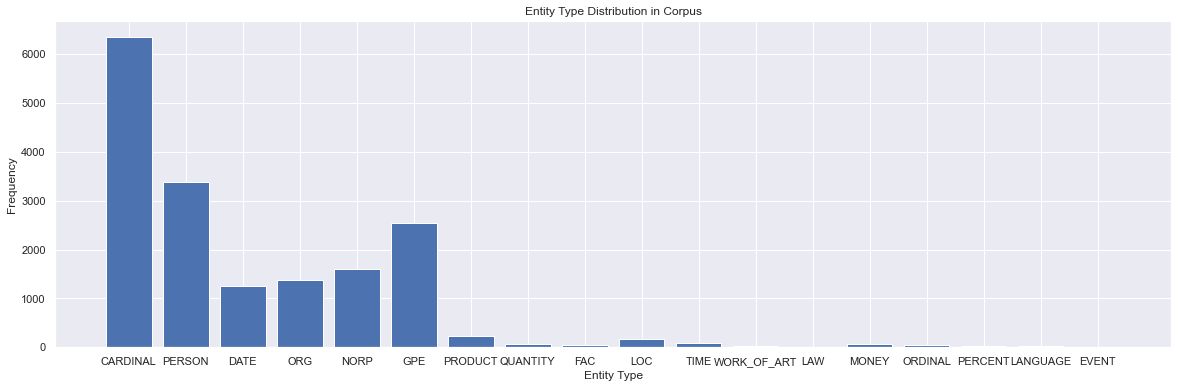

In [183]:
from collections import Counter

corpus_entities = []
for text in abc_comments_df['normalized_tokens']:
    doc = nlp(' '.join(text))
    entities = [ent.label_ for ent in doc.ents]
    corpus_entities.extend(entities)
entity_freq = Counter(corpus_entities)

plt.figure(figsize=(20, 6))
plt.bar(entity_freq.keys(), entity_freq.values())
plt.xlabel('Entity Type')
plt.ylabel('Frequency')
plt.title('Entity Type Distribution in Corpus')
plt.show()

NER Observations:
- The largest component of my YouTube comments corpus is CARDINAL representing numerical values, this might be caused by frequent discussions of the virus spread and infection/death cases from COVID-19
- The second largest component is PERSON, which makes sense as we see a lot of mention of "Trump" and "Biden" from prioir analysis. These discussions on person names may be caused by criticism or approval of Trump's pandemic policies or the upcoming December president election.
- Another large component is GPE (Geopolitical Entity) such as countries, cities, and states, which is also extremely relevant to the discussion of COVID-19 news as the pandemic is global.

In [193]:
# To calculate the Precision, Recall and F-score for the NER classification, 
# let's take a look at a sample of 50 tokens in the Feburary comments

counter = 0
predicted_labels = []
for token in feb_tokens:
    if counter < 50:
        counter += 1
        print(token.text, token.ent_type_)
        predicted_labels.append(token.ent_type_)
    else:
        break

jesus PERSON
christ PERSON
tell 
visionarie 
eat FAC
moringa FAC
leaf&#39 FAC
; 
virus 
build 
immune 
system 
virus 
13t09:49:16z CARDINAL
small 
state 
corona 
mask 
amen 
11t21:50:45z CARDINAL
realize 
bad 
situation 
get 
05t20:00:39z,"<a 
href=""https://youtu.be GPE
grc9x3mk6ho"">https://youtu.be 
grc9x3mk6ho</a><br 
> 
subscribe 
< 
br 
> 
like 
< 
br 
> 
shear 
< 
br 
> 
comment 
plz 
plz 
plz 
29t20:35:25z,"<a CARDINAL
href=""https://youtu.be GPE
br9edrzh7ok"">https://youtu.be 
br9edrzh7ok</a 
> 


In [198]:
for i, label in enumerate(predicted_labels):
    if label == '':
        predicted_labels[i] = 'O'

predicted_labels

['PERSON',
 'PERSON',
 'O',
 'O',
 'FAC',
 'FAC',
 'FAC',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'CARDINAL',
 'O',
 'O',
 'O',
 'O',
 'O',
 'CARDINAL',
 'O',
 'O',
 'O',
 'O',
 'O',
 'GPE',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'CARDINAL',
 'GPE',
 'O',
 'O',
 'O']

In [205]:
# Go through the first 50 tokens and manually assign NER labels to them as our true labels
true_labels = ['PERSON','PERSON','O','O','O','O','O','O','O','O','O','O','O','CARDINAL','O','O','O','O','O','CARDINAL','O','O','O','O','CARDINAL','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','CARDINAL','O','O','O','O',]

from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(true_labels, predicted_labels, labels=['PERSON'], average=None)
recall = recall_score(true_labels, predicted_labels, labels=['PERSON'], average=None)
f1 = f1_score(true_labels, predicted_labels, labels=['PERSON'], average=None)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F-score: {f1}')

Precision: [1.]
Recall: [1.]
F-score: [1.]


## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction.

We will be using spaCy's built in dependancy parser to go about exploring the tree.
Note that unlike previous examples, large corpuses or collections of sentences don't give us as much information, so we will be navigating smaller sentences.

Let us start by exploring noun chunks. Noun chunks are “base noun phrases” – flat phrases that have a noun as their head. You can think of noun chunks as a noun plus the words describing the noun – for example, “the lavish green grass” or “the world’s largest tech fund”. To get the noun chunks in a document, simply iterate over the sentences noun chunks.

In [202]:
from spacy import displacy

In [203]:
doc = nlp("Autonomous cars shift insurance liability toward manufacturers")

In [204]:
displacy.render(doc, style='dep')

In [206]:
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

Autonomous cars cars nsubj shift
insurance liability liability dobj shift
manufacturers manufacturers pobj toward


spaCy uses the terms head and child to describe the words connected by a single arc in the dependency tree. The term dep is used for the arc label, which describes the type of syntactic relation that connects the child to the head. As with other attributes, the value of .dep is a hash value. You can get the string value with .dep_.

For your reference:

Text: The original token text.

Dep: The syntactic relation connecting child to head.

Head text: The original text of the token head.

Head POS: The part-of-speech tag of the token head.

Children: The immediate syntactic dependents of the token.

In [207]:
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

Autonomous amod cars NOUN []
cars nsubj shift VERB [Autonomous]
shift ROOT shift VERB [cars, liability, toward]
insurance compound liability NOUN []
liability dobj shift VERB [insurance]
toward prep shift VERB [manufacturers]
manufacturers pobj toward ADP []


Because the syntactic relations form a tree, every word has exactly one head. You can therefore iterate over the arcs in the tree by iterating over the words in the sentence. This is usually the best way to match an arc of interest — from below:

In [208]:
from spacy.symbols import nsubj, VERB

In [209]:
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{shift}


You can *also* navigate from above. It isn't as efficient though.

In [210]:
verbs = []
for possible_verb in doc:
    if possible_verb.pos == VERB:
        for possible_subject in possible_verb.children:
            if possible_subject.dep == nsubj:
                verbs.append(possible_verb)
                break

In [211]:
print(verbs)

[shift]


### Iterating around the local tree
A few more convenience attributes are provided for iterating around the local tree from the token. Token.lefts and Token.rights attributes provide sequences of syntactic children that occur before and after the token. Both sequences are in sentence order. There are also two integer-typed attributes, Token.n_lefts and Token.n_rights that give the number of left and right children.

In [212]:
doc = nlp("bright red apples on the tree")
print([token.text for token in doc[2].lefts])  # ['bright', 'red']
print([token.text for token in doc[2].rights])  # ['on']
print(doc[2].n_lefts)  # 2
print(doc[2].n_rights)  # 1

['bright', 'red']
['on']
2
1


You can get a whole phrase by its syntactic head using the Token.subtree attribute. This returns an ordered sequence of tokens. You can walk up the tree with the Token.ancestors attribute, and check dominance with Token.is_ancestor

In [213]:
doc = nlp("Credit and mortgage account holders must submit their requests")

root = [token for token in doc if token.head == token][0]
subject = list(root.lefts)[0]
for descendant in subject.subtree:
    assert subject is descendant or subject.is_ancestor(descendant)
    print(descendant.text, descendant.dep_, descendant.n_lefts,
            descendant.n_rights,
            [ancestor.text for ancestor in descendant.ancestors])

Credit nmod 0 2 ['account', 'holders', 'submit']
and cc 0 0 ['Credit', 'account', 'holders', 'submit']
mortgage conj 0 0 ['Credit', 'account', 'holders', 'submit']
account compound 1 0 ['holders', 'submit']
holders nsubj 1 0 ['submit']


Finally, the .left_edge and .right_edge attributes can be especially useful, because they give you the first and last token of the subtree. This is the easiest way to create a Span object for a syntactic phrase. Note that .right_edge gives a token within the subtree — so if you use it as the end-point of a range, don’t forget to +1!

In [214]:
span = doc[doc[4].left_edge.i : doc[4].right_edge.i+1]
with doc.retokenize() as retokenizer:
    retokenizer.merge(span)
for token in doc:
    print(token.text, token.pos_, token.dep_, token.head.text)

Credit and mortgage account holders NOUN nsubj submit
must AUX aux submit
submit VERB ROOT submit
their PRON poss requests
requests NOUN dobj submit


In [215]:
displacy.render(doc, style='dep')

### Information Extraction

How can dependancy graphs be useful? We can extract information from the sentences based on relationships between words within parsed phrases. Let us see if we can do this to glean any information, from, say, our movies dataset.

How violent are the movies? Who is killing who?

In [216]:
movie_violences = {}

In [217]:
from tqdm import tqdm
tqdm.pandas()

for index, row in movie_df[0:100].iterrows():
    text = ' '.join(row['Tokenized Texts'])
    movie_violences[row['Movie Name']] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'kill':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0:
                movie_violences[row['Movie Name']][0].append(subject)
            if object_ is not 0:
                movie_violences[row['Movie Name']][1].append(object_)

<>:18: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:18: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_8213/2514465833.py:18: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if subject is not 0:
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_8213/2514465833.py:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if object_ is not 0:


In [218]:
movie_violences

{'Animal Crackers': ([], []),
 'Anna Christie': (['I', 'I'], ['them', 'all', 'you', 'Glory', 'you']),
 'Ladies of Leisure': ([], []),
 'Over the Hill': (['I', 'This'], ['Ma']),
 'Design for Living': ([], []),
 'Lady for a Day': (['It'], ['yourself', 'Louise']),
 'Lady Killer': (['that'], ['horse']),
 'The Mind Reader': (['woman'], ['herself']),
 'Here Is My Heart': ([], ['herself']),
 'Peculiar Penguins': ([], []),
 'Sadie McKee': (['You', 'I'], ['SOBBING', 'you']),
 'Star of Midnight': (['you', 'I', 'They'], ['story', 'him', 'dal', 'her']),
 'The Littlest Rebel': (['men'], ['army']),
 'The Robber Kitten': ([], []),
 'Charlie Chan at the Circus': ([], ['Kinney']),
 'Charlie Chan at the Opera': (['I'], ['me', 'him', 'you', 'intrusion']),
 'Charlie Chan at the Race Track': (['shoe', 'you'], ['major']),
 'The Prisoner of Shark Island': (['what'], ['husband']),
 'The Prince and the Pauper': ([], ['me']),
 'The Lady Vanishes': (['They'], ['lot']),
 'Holiday': ([], []),
 "Donald's Cousin Gus

That's pretty neat: we can see who tried to kill who, or at least talked about it. A lot of 'I' killing 'you', as we'd imagine. What else can we see?

The movie, about time, which is about time travel, funnily enough has:
`'About Time': (['I'], ['Hitler'])`

## <font color="red">*Exercise 6*</font>

<font color="red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceive to play in the social world inscribed by your texts?

In [222]:
abc_comments_df['text'].iloc[0]

'PublishedAt,Comment\r\n2020-09-11T20:09:00Z,I’m here after the trump tapes.....\r\n2020-06-14T20:29:16Z,Guys guess what\r\n2020-06-14T20:28:22Z,I wish we can go back in time and tell people that the virus\r\n2020-04-22T15:09:29Z,Stop promoting fake news .....Stop promoting fake news ......Stop promoting fake news ......Stop promoting fake news ......Stop promoting fake news\r\n2020-04-01T02:32:24Z,Pray for the world to come through the pandemic\r\n2020-02-26T15:19:22Z,"Repent, cry out to God for forgiveness through Jesus Christ he is the only way. Time on this earth is running out the kingdom or heaven is at hand. All these biblical signs going in in the earth should be a wake up call for a lot you. Acts <a href=""https://www.youtube.com/watch?v=L3T-3lvgC18&amp;t=2m38s"">2:38</a> Repent, and be baptized in the name of Jesus Christ for a remission of your sins, and ye shall receive the gift of the Holy Ghost. May God have mercy on all our souls."\r\n2020-02-26T16:38:53Z,"1 John 1:9 Con

In [227]:
import re

corpus = abc_comments_df['text'].iloc[0]
corpus = re.sub(r'<[^>]*>', '', corpus)  # Remove HTML tags
corpus = re.sub(r'\r\n', ' ', corpus)  # Replace '\r\n' with space
corpus = re.sub(r'\s+', ' ', corpus).strip()  # Remove extra whitespaces
corpus = re.sub(r'\b\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}Z\b', '', corpus)  # Remove date-time patterns

print(corpus)

PublishedAt,Comment ,I’m here after the trump tapes..... ,Guys guess what ,I wish we can go back in time and tell people that the virus ,Stop promoting fake news .....Stop promoting fake news ......Stop promoting fake news ......Stop promoting fake news ......Stop promoting fake news ,Pray for the world to come through the pandemic ,"Repent, cry out to God for forgiveness through Jesus Christ he is the only way. Time on this earth is running out the kingdom or heaven is at hand. All these biblical signs going in in the earth should be a wake up call for a lot you. Acts 2:38 Repent, and be baptized in the name of Jesus Christ for a remission of your sins, and ye shall receive the gift of the Holy Ghost. May God have mercy on all our souls." ,"1 John 1:9 Confess your sins, and he is faithful and just to forgive them. May God have mercy on your soul stay safe my friend." ,"DOES NO ANY TROUBLE TO HEAL THIS... &lt;&lt;&lt;&gt;&gt; If to somebody is interesting this - In the year 2018 due th

In [235]:
sentences = sent_tokenize(corpus)
target_sentences = sentences[54:59]

for i, sentence in enumerate(target_sentences, start=1):
    print(f"Sentence {i}: {sentence}")

Sentence 1: Jesus Christ loves you" ,Clearly Trump is responsible for the spread of this disease.
Sentence 2: Why is Stephanopolous not reporting this?
Sentence 3: ,I don’t have anything against with Asian/Korea...etc people but I don’t think they should go to any other state or country bc they could be infected and then more people are gon get sick and maybe die ,What a good way to start the new year..it&#39;s a sad situation ,Australia is on fire there’s a virus and Iran vs US damn our world really falling apart ,Bio weapon... ,
Sentence 4: E ,Well we going to die well not everyone.......
Sentence 5: I’m going to Greenland guys see you ,I&#39;m scared and I can only imagine how Chinese people are feeling right now 💔 this is absolutely frightening and doesn&#39;t help my ongoing habit of being a hypochondriac with anxiety.


In [236]:
for i, sentence in enumerate(target_sentences, start=1):
    doc = nlp(sentence)
    displacy.render(doc, style='dep')

Observations based on the 5 sentences sampled from the YouTube news comments
- Since comments under YouTube news clips are expected to be short (such as the second one) and potentially incohesive, the dependency parsing above are expected to be shallow (not very deep).
- However, some of the sentences I sampled (such as the third one and the last one) have complex sentence structures hence deep parsing structures.

Noun Phrases (NPs): Identify and extract noun phrases by analyzing the syntactic structure of the parse tree. This allows you to understand which words are collocated within noun phrases.

Adjective-Noun Relationships: Extract pairs of adjectives and nouns to understand the descriptive relationships between adjectives and the nouns they modify.

- DET will likely to point to a crucial nouns for analysis
- NPs to identify and extract noun phrases and help us understand which words are collocated within noun phrases
- Extract pairs of adjectives and nouns to understand the descriptive relationships between adjectives
- The relationship between actor and action can be demonstrated from the parsing tree clearly, for example Trump (PROPN), is (AUX), responsible (ADJ) and the following result "for the spread of disease"
- Based on the parsing tree we can even conduct some preliminary sentiment analysis by checking relationships between sentiment-bearing words (e.g., adjectives) and their associated targets (e.g., nouns). For example "I'm scared and can only imagine how Chinese people are feeling"

For the first sentence let's choose a focal word of "Trump":
- The word "Trump" is the subject of the verb "is responsible." Analyzing the dependency relation reveals people's negative attitude toward him regarding to his action in relation to the spread of the disease.
- Social Relationships: an indication of social relationships or roles that "Trump" is perceived to play in the context of the disease spread.

# Distributional distances

If we want to compare different corpora, we need a distance or divergence that compares the two distributions.

We will use the:

+ Kullback-Leibler (KL) divergence
+ $\chi^2$ divergence
+ Kolmogorov-Smirnov (KS) distance
+ Wasserstein distance

### Kullback-Leibler and $x^2$ divergences ###

KL and $\chi^2$ divergences are members of the broader <a "href=https://en.wikipedia.org/wiki/F-divergence" target="_blank">$f$-divergence</a> family, a function of $D_f (P || Q)$ that calculates the difference between two probability distributions P and Q. The KL $f(t)$ is $ t \text{ log } t $, while the $\chi^2$ is $t^2-1$. KL comes from information and $\chi^2$ from measure theory. As such, the KL divergence computes the relative entropy between two distributions--how they differ in bits, while the $\chi^2$ whether the same statistical inferences can be drawn from them both.  

Specifically, given two discrete probability distributions $P$ and $Q$, the Kullback-Leibler divergence from $Q$ to $P$ is defined as:

$D_{\mathrm{KL}}(P\|Q) = \sum_i P(i) \, \log\frac{P(i)}{Q(i)}$.

The [scipy.stats.entropy()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) function does the calculation for you, which takes in two arrays of probabilities and computes the KL divergence. Note that the KL divergence is in general not commutative, i.e. $D_{\mathrm{KL}}(P\|Q) \neq D_{\mathrm{KL}}(Q\|P)$ .

Also note that the KL divernce is the sum of elementwise divergences. Scipy provides [scipy.special.kl_div()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html#scipy-special-kl-div) which calculates elementwise divergences for you.

The $\chi^2$ Divergence is defined as:

$D_{\mathrm{\chi^2}}(P\|Q) = \sum_i \left(\frac{P(i)}{Q(i)}-1\right)^2$.

This is also noncommutative, and the code can be drawn directly from scipy.

### Kolmogorov-Smirnov ###

The two-sample Kolmogovorov-Smirnov test statistic calculates the distance between the cumulative distribution function of the two distributions to be compared, and, along with the $x^2$ divergence, is among the most common approaches two calculating a distance in statistics. It can be interpreted as a test of whether two distributions are drawn from the same underlying distribution. As with the others, the code is readily available in scipy.

### Wasserstein Distance ###

When this is computed on a Euclidian metric structure (e.g., numbers of words), this is also known as the earth mover’s distance, because it can be seen as the minimum amount of "work" required to transform $P$ into $Q$, where "work" is measured as the amount of distribution weight that must be moved, multiplied by the distance it has to be moved.

### Computing ###

To do this we will need to create the arrays, lets compare the Whitehouse releases with the Kennedy releases. First we have to download them and load them into a DataFrame.

In [237]:
kenReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Kennedy', maxFiles = 10)
kenReleases[:5]

,name,text,path,html_url,download_url
0,01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,raw/Kennedy/01Apr2005Kennedy14.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
1,01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,raw/Kennedy/01Aug2005Kennedy12.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
2,01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy10.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
3,01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy11.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
4,01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy12.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...


Then we can tokenize, stem and remove stop words, like we did for the Whitehouse press releases

In [238]:
kenReleases['tokenized_text'] = kenReleases['text'].apply(lambda x: word_tokenize(x))
kenReleases['normalized_tokens'] = kenReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

Now we need to compare the two collection of words, remove those not found in both, and assign the remaining ones indices.

In [239]:
whWords = set(whReleases['normalized_tokens'].sum())
kenWords = set(kenReleases['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = whWords & kenWords

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict['student']

193

Now we can count the occurrences of each word in the corpora and create our arrays. Note that we don't have to use numpy arrays as we do here. We could just use a list, but the arrays are faster in numpy so we encourage you to get in the habit of using them.

In [240]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

whProbArray = makeProbsArray(whReleases['normalized_tokens'], overlapWordsDict)
kenProbArray = makeProbsArray(kenReleases['normalized_tokens'], overlapWordsDict)
kenProbArray.sum()
#There is a little bit of a floating point math error
#but it's too small to see with print and too small matter here

1.0000000000000002

We can now compute the KL divergence. Pay attention to the asymmetry. Use [the Jensen–Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence), which is the average KL divergence between each distribution and the average of both distributions (i.e., the midpoint), if you want symmetry.

In [241]:
wh_kenDivergence = scipy.stats.entropy(whProbArray, kenProbArray)
print (wh_kenDivergence)
ken_whDivergence = scipy.stats.entropy(kenProbArray, whProbArray)
print (ken_whDivergence)

0.6369388336069719
0.5818824611674385


Then, we can do the elementwise calculation and see which words best distinguish the two corpora.

In [242]:
wh_kenDivergence_ew = scipy.special.kl_div(whProbArray, kenProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = wh_kenDivergence_ew
kl_df[:10]

,word,elementwise divergence
0,application,0.000054
1,influence,0.000054
2,find,0.001212
3,clinton,0.000811
4,year,0.001648
5,office,0.000395
6,important,0.000484
7,lose,0.005699
8,forward,0.000108
9,counter,0.000054


In [243]:
kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

,word,elementwise divergence
137,iraq,0.094524
81,bush,0.047893
226,american,0.025754
156,stem,0.023613
60,law,0.022835
14,department,0.018926
102,member,0.013172
116,war,0.012601
132,program,0.011258
170,country,0.010142


Now we will apply what we learned today
First, let's transform every text into normalized tokens. Note that in this first step, no stopword is removed.
We'll use only the first 11 movies: you are welcome to try more.

In [244]:
corpora = []
for index, row in movie_df.iterrows():
    if len(corpora) > 10:
        break
    corpora.append(row['Tokenized Texts'])

Then, let's separate the normalized tokens into stopwords and non-stopwords.

In [245]:
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    corpora_s.append(s)
    corpora_nons.append(nons)

Define some covenient funtions for calculating divergence and distances.

In [246]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

Now we will calculate the KL divergence for each pair of corpora, turn the results into a matrix, and visualize the matrix as a heatmap. Recall that $D_{\mathrm{KL}}(P\|Q)$ measures the amount of information loss when $Q$ is used to approximate $P$. Here, the rows are the $P$s used for calculating KL divergences, and the columns are the $Q$s. So, each cell measures the amount of information loss when the word distribution of the column text is used to approximate the word distribution of the row text. Because the KL divergence is directional, such that the divergence of $P$ from $Q$ is different from the same of $Q$ from $P$, the matrix is assymetric and contains unique information above and below the diagonal. The same is true for the $\chi^2$ divergence.

In [247]:
len(corpora)

11

In [248]:
fileids = list(movie_df['Movie Name'])[0:11]

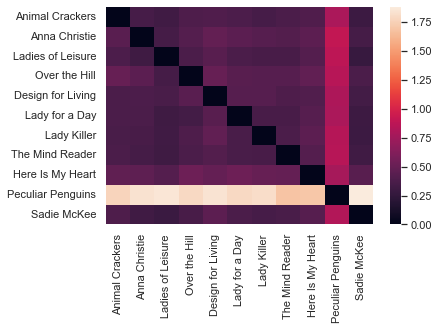

In [255]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()


To reveal more patterns, let's do a multidimensional scaling of the matrix.

/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


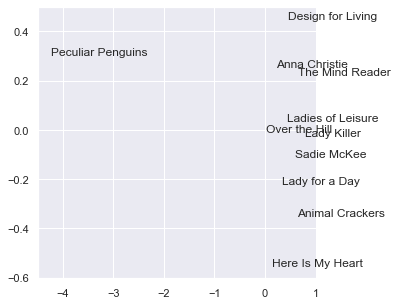

In [256]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (5,5))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

A co-respondent's course and The Chain Gang are away from the others - any guesses why?

We may just want to focus on the distrbution of stopwords or non-stopwords. Let's do the analysis again first for stopwords and then for non-stopwords.

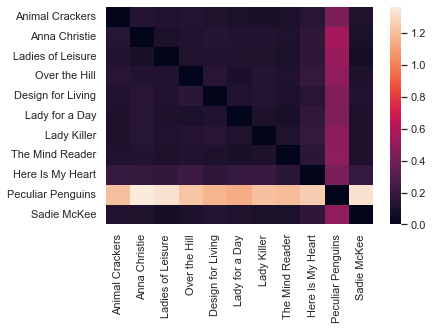

In [257]:
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

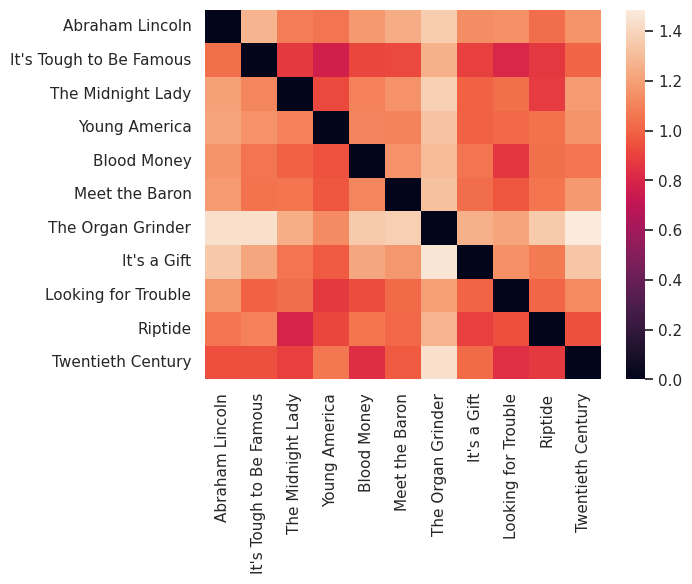

In [ ]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

For the KS distance:

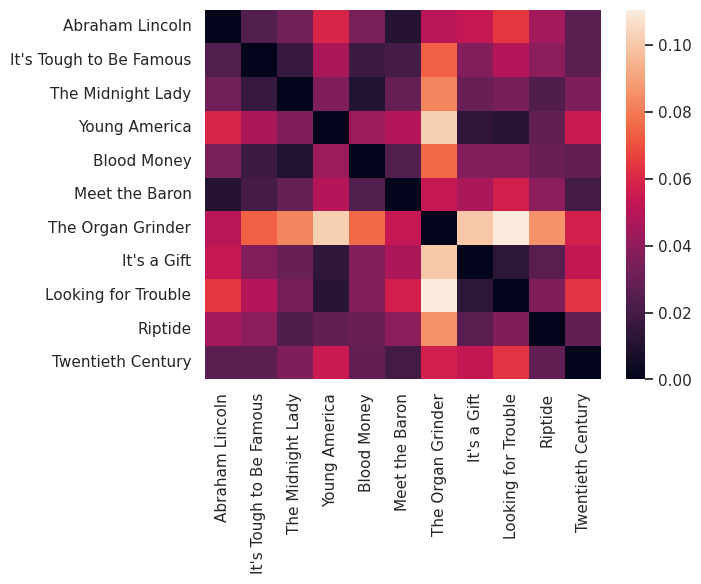

In [ ]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

And finally for the Wasserstein or "earth mover's" Distance.

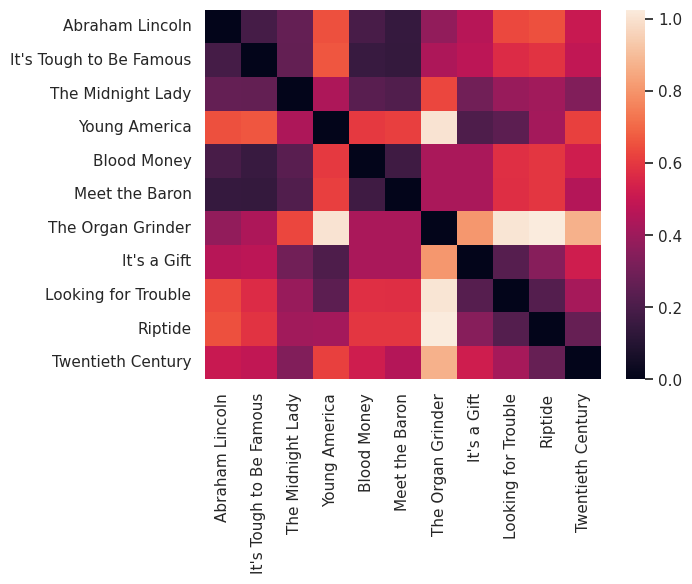

In [ ]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

You can see that decade X is highly divergent and this makes reading the plot somewhat difficult. Let's fix this by taking the log of each cell, which will reduce the distance of decode X from other texts as an outlier.

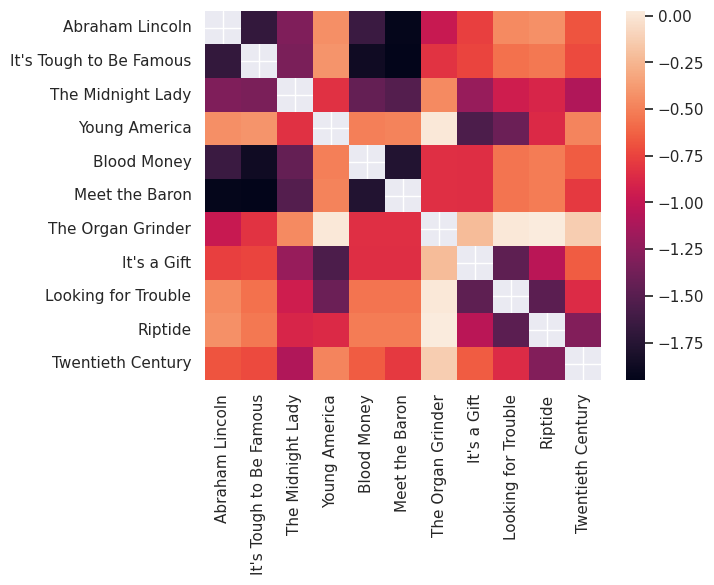

In [ ]:
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

We only tried 11 movies, and from the same time period, so our signals might not be too interesting. What about different time periods?

An interesting experiment to maybe get some clearer signals: documents by decade in the Davies Corpus Of Historial American English (COHA) and see if we can detect patterns between them.

If we want to rerun this on a new data set of our own composition, we can be a bit more efficient with our coding. Let's use the Shakespeare texts from last week as example. Here we again make use of our convenient `lucem_illud` functions, namely `loadTextDirectory`, which is found in [loaders.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/loaders.py).

In [258]:
def loadTextDirectory(targetDir, encoding = 'utf-8'):
    text = []
    fileName = []

    for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
        with open(file.path, encoding = encoding) as f:
            text.append(f.read())
        fileName.append(file.name)
    return pandas.DataFrame({'text' : text}, index = fileName)

In [ ]:
shakespeare_df = lucem_illud.loadTextDirectory('../data/Shakespeare')

Now we stem and remove stopwords

In [ ]:
shakespeare_df['tokenized_text'] = shakespeare_df['text'].apply(lambda x: word_tokenize(x))
shakespeare_df['normalized_tokens'] = shakespeare_df['tokenized_text'].apply(lambda x: normalizeTokens(x))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Create the corpus file and generate the heatmap:

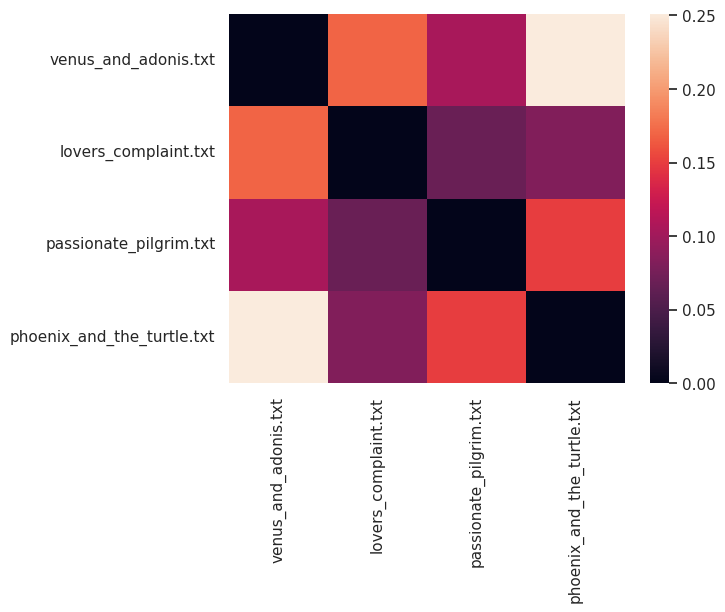

In [ ]:
measure = 'KS' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 10 #The bigger this number the slower it will run, you can also try selecting your own plays
fileids_sp = list(shakespeare_df[:num_of_texts].index)
corpora_sp = list(shakespeare_df[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

What are "The Passionate Pilgrim" and "The Phoenix and the Turtle"? Little known poems by Shakespeare that are unsurprisingly hard to classify, as they are so different from everything else he wrote.

## <font color="red">*Exercise 7*</font>

<font color="red">Construct cells immediately below this that calculate the KL and $\chi^2$ divergences, and the KS and Wasserstein distances between four separate corpora, plot these with heatmaps, and then array them in two dimensions with multidimensional scaling as above. What does this reveal about relations between the corpora? Which analysis (and divergence or distribution) distinguishes the authors or documents better?

**Stretch**: Calculate the [Jensen-Shannon Divergence](https://en.wikipedia.org/wiki/Jensen–Shannon_divergence) between your four corpora. What is the relationship between the KL and JS divergences?</font>

In [275]:
columns_to_include = ["name", "text"]
abc_copy = abc_comments_df[columns_to_include].copy(deep=True)
abc_copy = abc_copy[:4]
abc_copy

,name,text
0,abc2001_comments.csv,"PublishedAt,Comment\r\n2020-09-11T20:09:00Z,I’..."
1,abc2002_comments.csv,"PublishedAt,Comment\r\n2023-07-19T20:38:49Z,Je..."
2,abc2003_comments.csv,"PublishedAt,Comment\r\n2022-03-27T16:35:52Z,👏\..."
3,abc2004_comments.csv,"PublishedAt,Comment\r\n2020-04-10T04:42:59Z,""Q..."


In [276]:
abc_copy['tokenized_text'] = abc_copy['text'].apply(lambda x: word_tokenize(x))
abc_copy['normalized_tokens'] = abc_copy['tokenized_text'].apply(lambda x: normalizeTokens(x))

In [278]:
abc_copy['normalized_tokens'] = abc_copy['normalized_tokens'].apply(lambda x: x[3:])

In [281]:
abc_copy

,name,text,tokenized_text,normalized_tokens
0,abc2001_comments.csv,"PublishedAt,Comment\r\n2020-09-11T20:09:00Z,I’...","[PublishedAt, ,, Comment, 2020-09-11T20:09:00Z...","[m, trump, tape, 14t20:29:16z, guy, guess, 14t..."
1,abc2002_comments.csv,"PublishedAt,Comment\r\n2023-07-19T20:38:49Z,Je...","[PublishedAt, ,, Comment, 2023-07-19T20:38:49Z...","[jesus, christ, tell, visionarie, eat, moringa..."
2,abc2003_comments.csv,"PublishedAt,Comment\r\n2022-03-27T16:35:52Z,👏\...","[PublishedAt, ,, Comment, 2022-03-27T16:35:52Z...","[👏, 11t14:55:54z, look, move, korea, 24t02:53:..."
3,abc2004_comments.csv,"PublishedAt,Comment\r\n2020-04-10T04:42:59Z,""Q...","[PublishedAt, ,, Comment, 2020-04-10T04:42:59Z...","[queen, elizabeth, royal, throne, 💫, ✨, ☔, 🚥, ..."


In [299]:
corpus1 = abc_copy['normalized_tokens'].iloc[0]
corpus2 = abc_copy['normalized_tokens'].iloc[1]
corpus3 = abc_copy['normalized_tokens'].iloc[2]
corpus4 = abc_copy['normalized_tokens'].iloc[3]

corpora = [corpus1, corpus2, corpus3, corpus4]
fileids = ['Jan Comments', 'Feb Comments', 'March Comments', 'April Comments']

In [302]:
corpus1

['m',
 'trump',
 'tape',
 '14t20:29:16z',
 'guy',
 'guess',
 '14t20:28:22z',
 'wish',
 'time',
 'tell',
 'people',
 'virus',
 '22t15:09:29z',
 'stop',
 'promote',
 'fake',
 'news',
 'stop',
 'promote',
 'fake',
 'news',
 'stop',
 'promote',
 'fake',
 'news',
 'stop',
 'promote',
 'fake',
 'news',
 'stop',
 'promote',
 'fake',
 'news',
 '01t02:32:24z',
 'pray',
 'world',
 'come',
 'pandemic',
 '26t15:19:22z',
 'repent',
 'cry',
 'god',
 'forgiveness',
 'jesus',
 'christ',
 'way',
 'time',
 'earth',
 'run',
 'kingdom',
 'heaven',
 'hand',
 'biblical',
 'sign',
 'go',
 'earth',
 'wake',
 'lot',
 'act',
 '<',
 'href=',
 'https',
 '//www.youtube.com',
 'watch',
 'v',
 '=',
 'l3t-3lvgc18',
 'amp',
 't=2m38s',
 '>',
 '2:38',
 '<',
 '/a',
 '>',
 'repent',
 'baptize',
 'jesus',
 'christ',
 'remission',
 'sin',
 'ye',
 'shall',
 'receive',
 'gift',
 'holy',
 'ghost',
 'god',
 'mercy',
 'soul',
 '26t16:38:53z',
 'john',
 '1:9',
 'confess',
 'sin',
 'faithful',
 'forgive',
 'god',
 'mercy',
 'soul

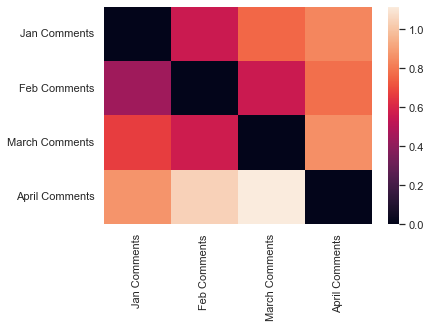

In [300]:
# KL divergence
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

The KL heatmap shows significant divergence between the corpora labeled "Jan Comments" and "April Comments," indicating that the language used in these two months differs significantly. KL divergence is asymmetric, which means that the divergence of P from Q is not the same as Q from P.

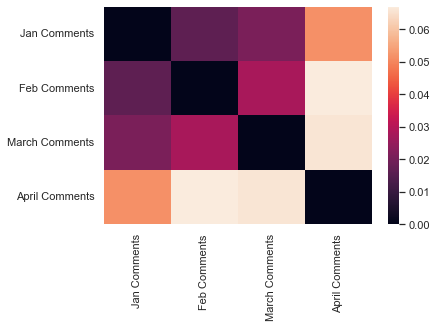

In [303]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

 The KS heatmap suggests that February and March comments are quite similar, as indicated by the lighter colors. This might be explained by the severe outbreak of COVID-19 pandemic in the U.S following January when the pandemic was not severe in the US but in China.

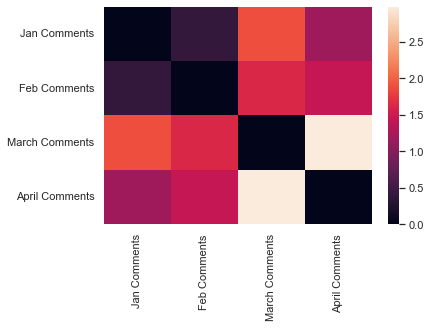

In [304]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

Similar to KL divergence, The Wasserstein heatmap suggests varying degrees of difference, with January and March comments showing a higher degree of difference compared to others. 

/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


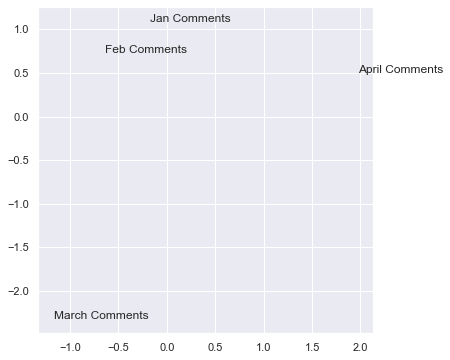

In [296]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

Since points that are closer together indicate more similar comment corpora, we see that January and Feburary has relatively similar comments while those of March and April are very distinctive.

From the plots, it seems that the Wasserstein distance shows the most pronounced differences between all the corpora, as indicated by the wider range of colors in the heatmap, suggesting that it might be distinguishing the authors or documents better in this particular case